In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from imblearn.datasets import fetch_datasets
from pathlib import Path
sys.path.append(str(Path.cwd().parents[1]))
from handle_results import HandleResults
from handle_data import HandleData
from evaluate_oversampler_cross_val import CrossValidation
from sklearn.metrics import auc

In [2]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, SVMSMOTE, ADASYN, BorderlineSMOTE
from sv_synthsonic import synthsonic
import smote_variants as sv

from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
HR = HandleResults()
HD = HandleData()
CV = CrossValidation()

In [4]:
home_folder = Path.cwd().parents[1]
plot_folder = home_folder.joinpath(home_folder, 'Plots')
path = home_folder.joinpath(home_folder, 'CSV_results')
df_info = pd.read_csv(path.joinpath('dataset_info.csv'))
df = pd.read_csv(path.joinpath('Cross_validation', 'Cross_validation.csv'), index_col=0)

# PCA plots original datasets

/Users/tristenmarto/Documents/Studie/Thesis/Synthsonic_data_analysis/handle_data.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize = (12,7))


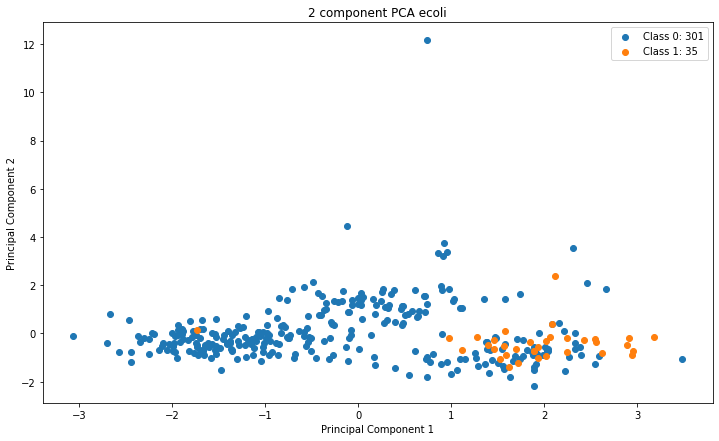

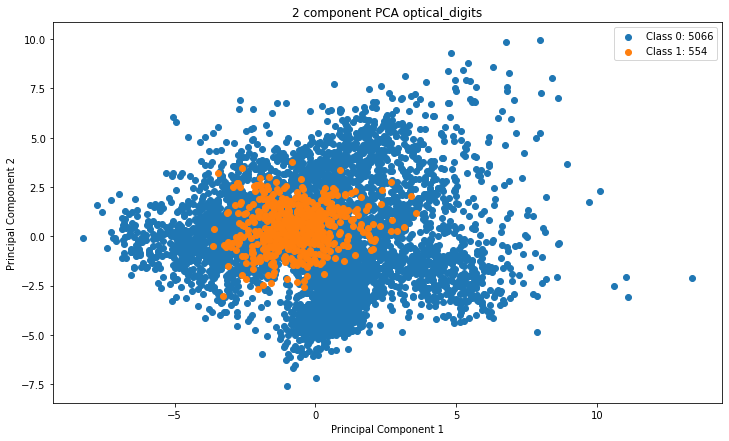

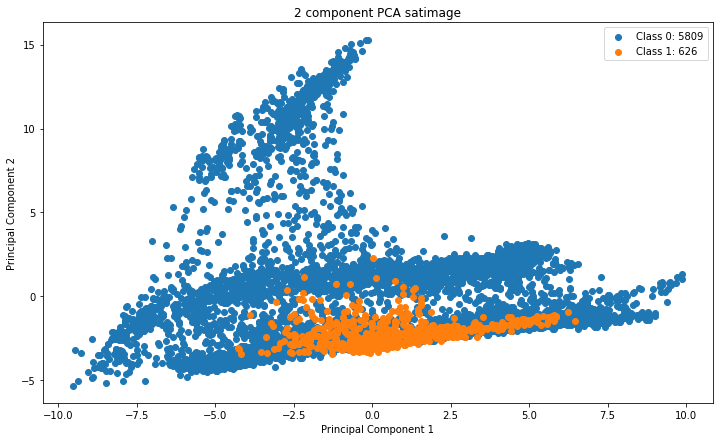

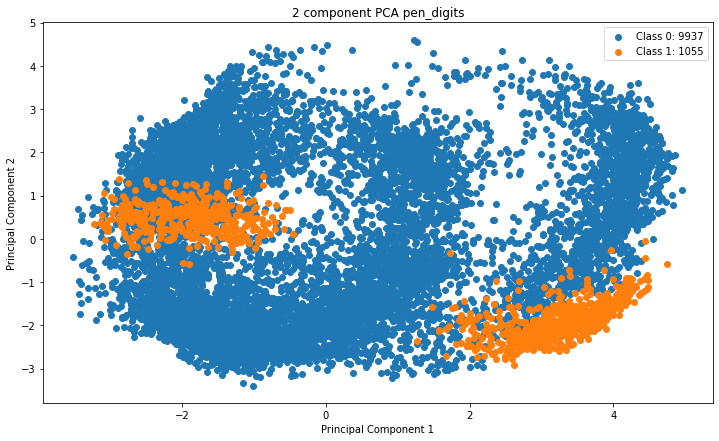

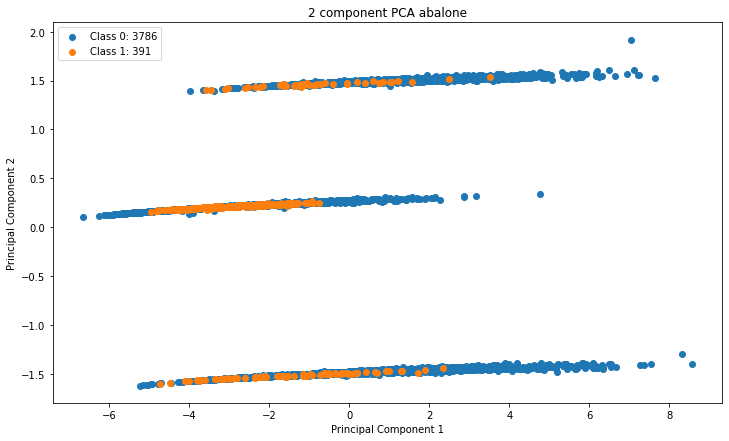

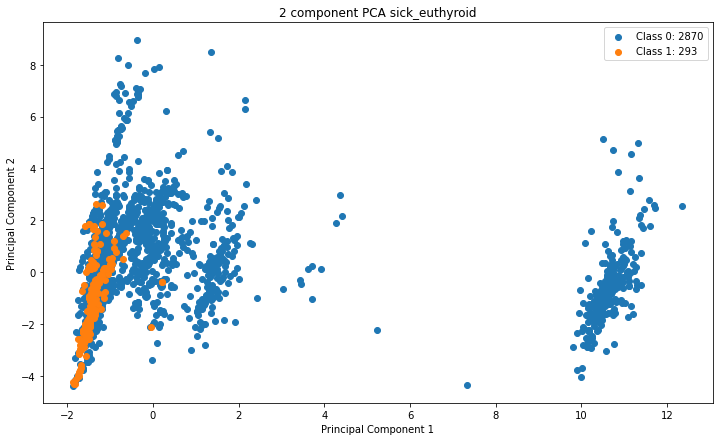

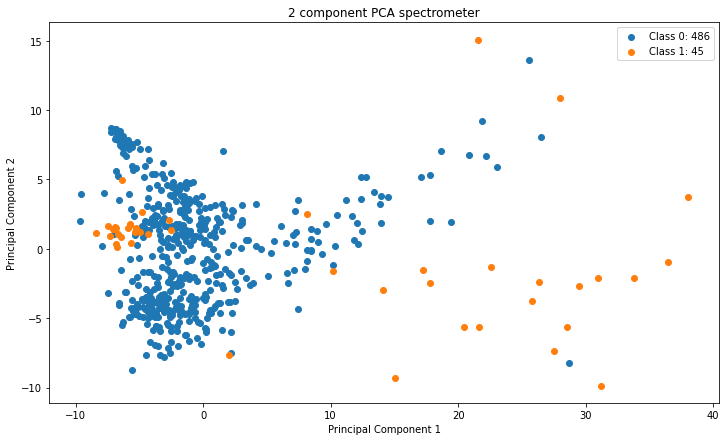

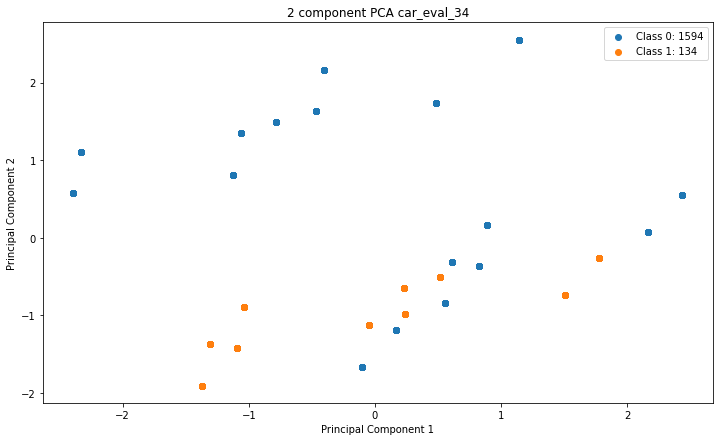

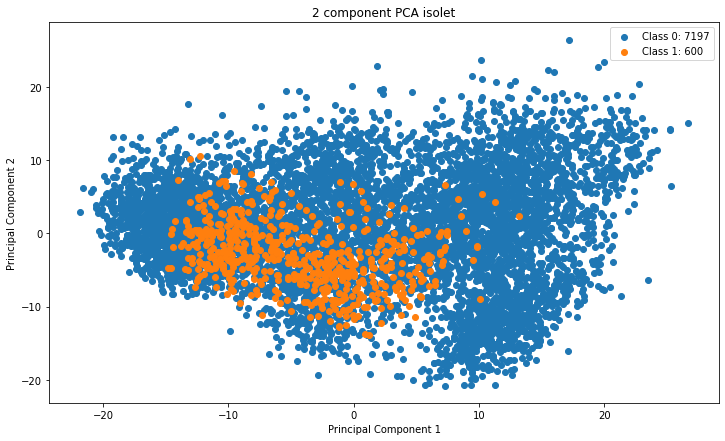

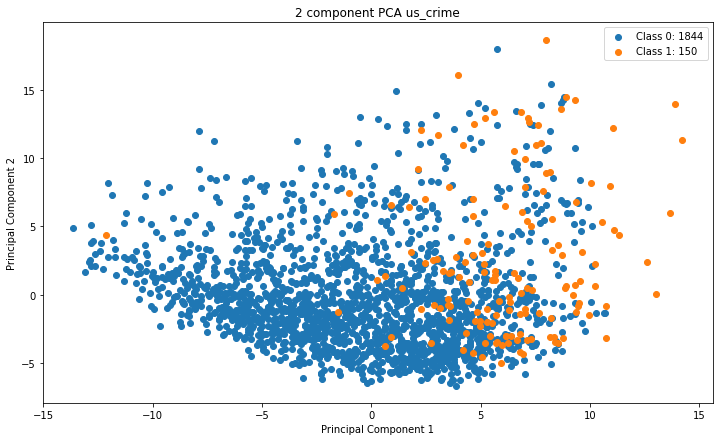

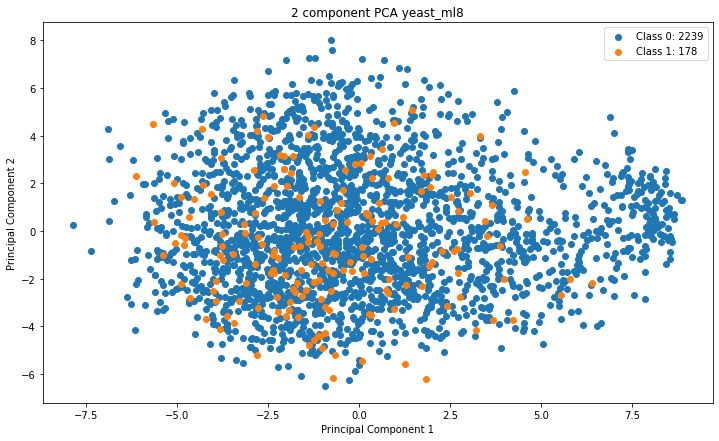

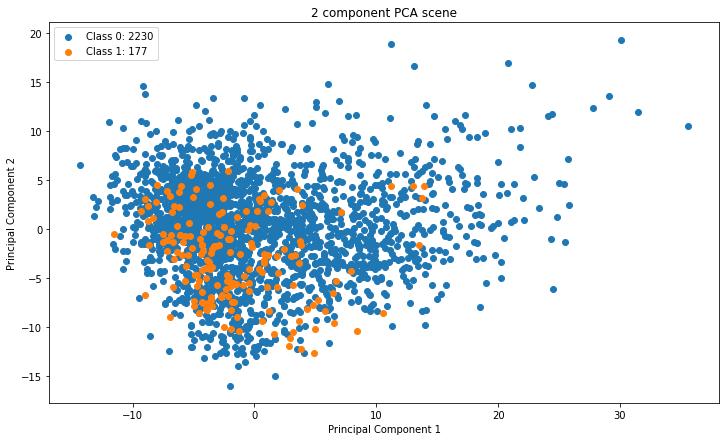

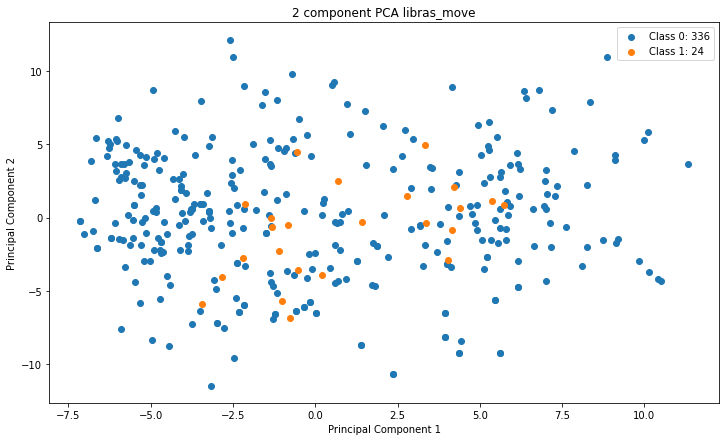

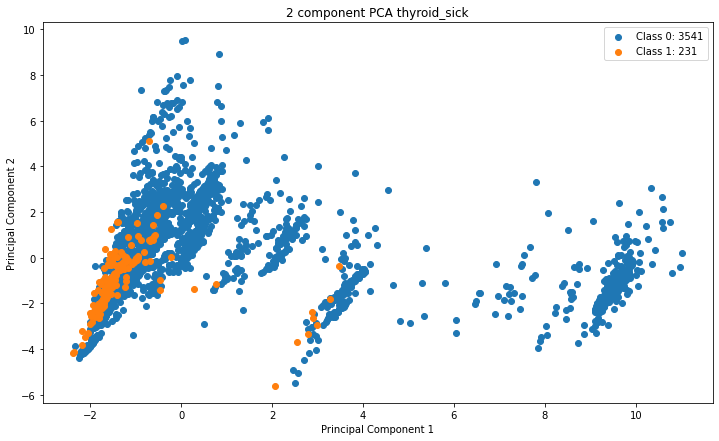

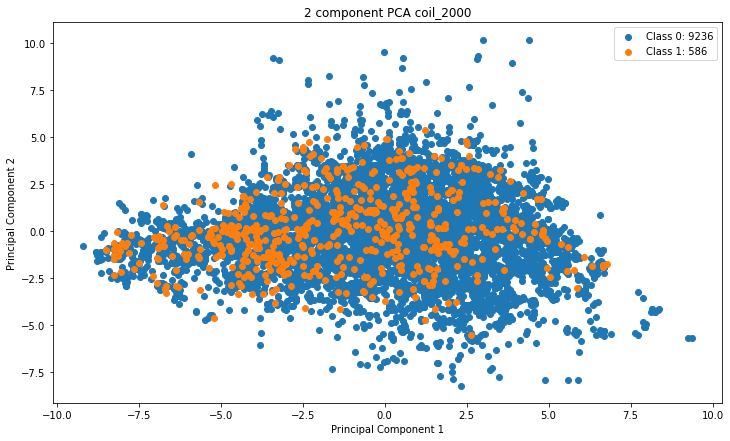

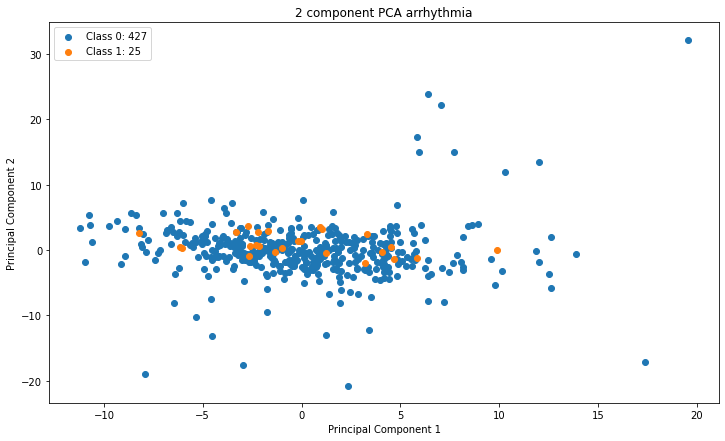

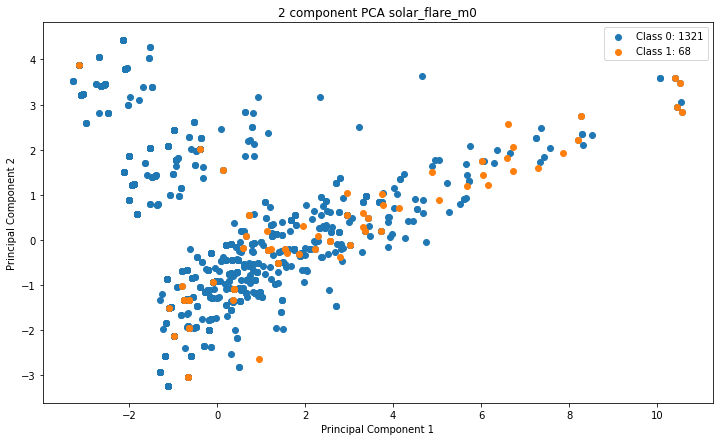

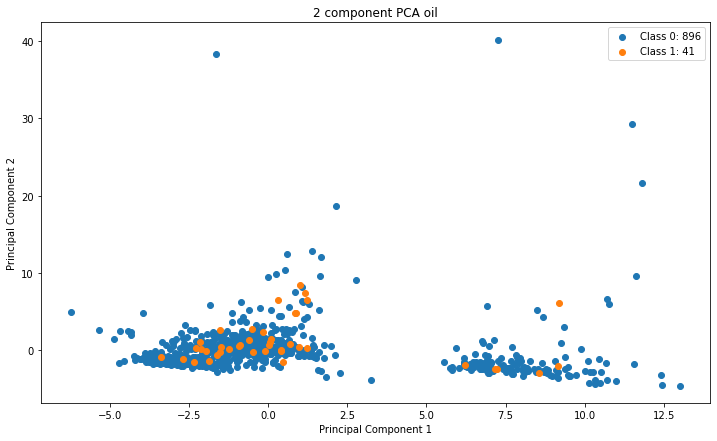

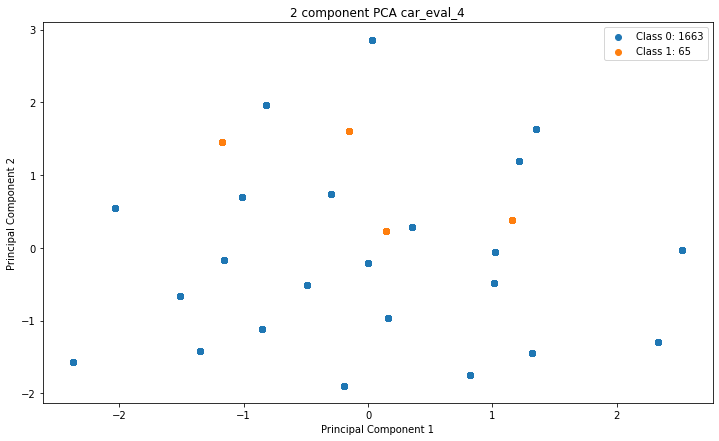

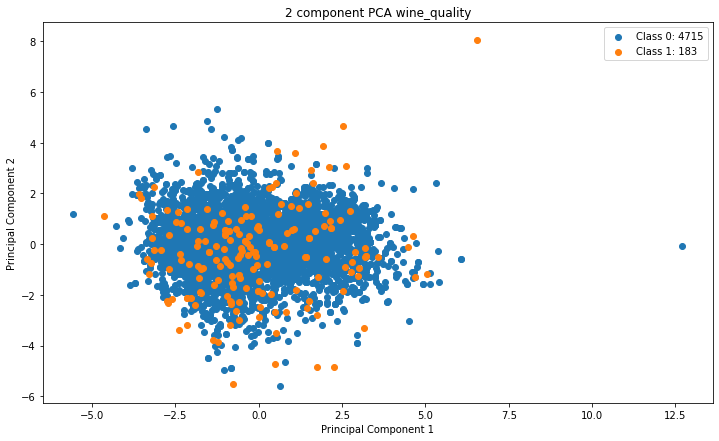

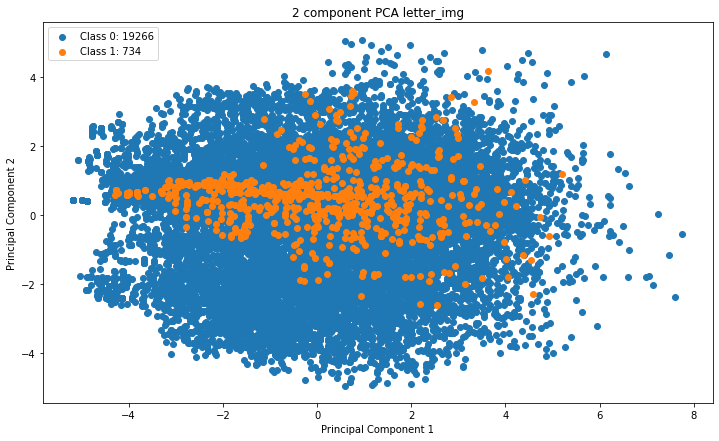

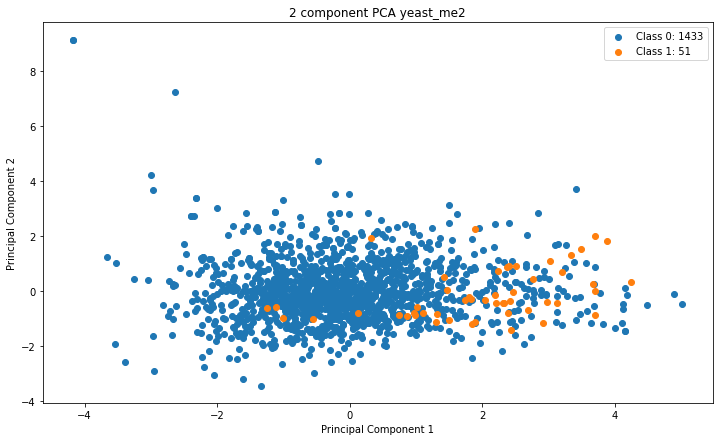

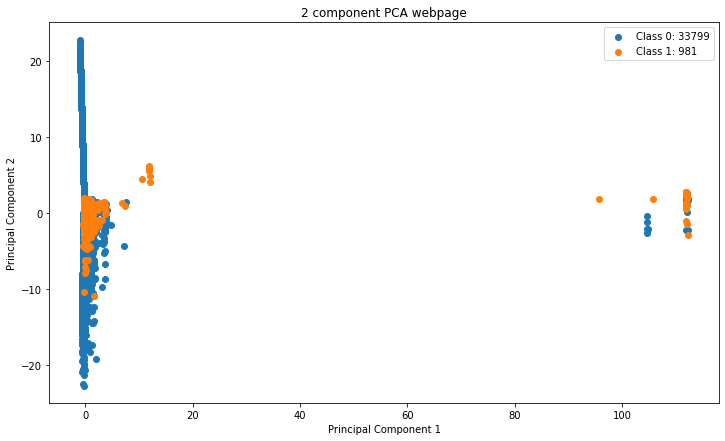

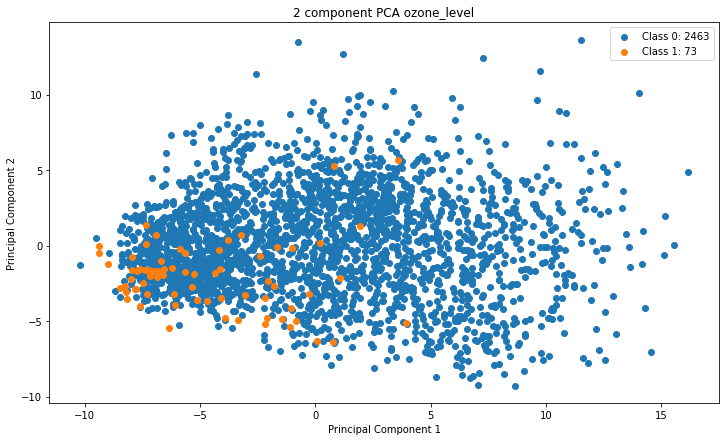

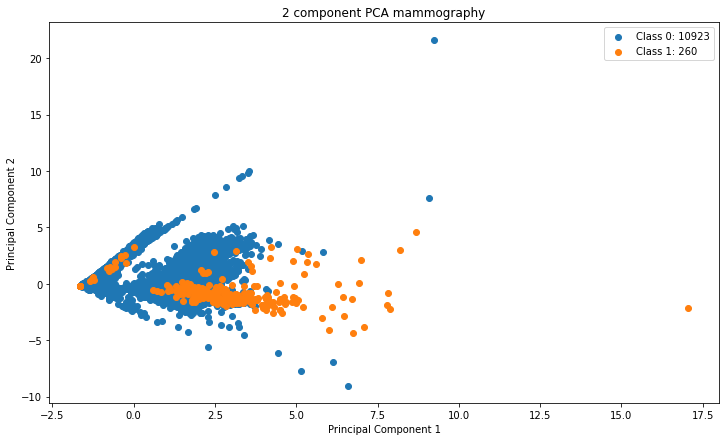

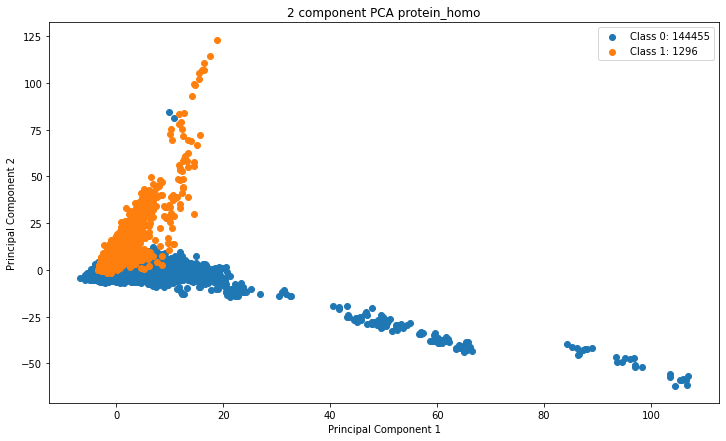

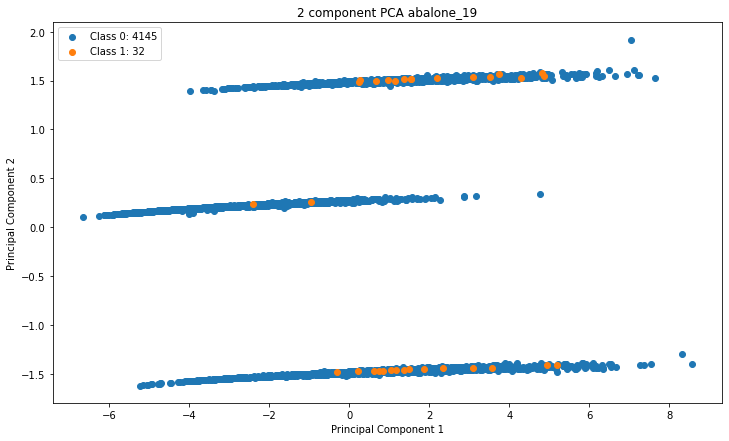

In [5]:
datasets = fetch_datasets()
for dataset, values in datasets.items() :
    
    HD.pca_plot(values['data'],values['target'], title=dataset)

# performance on low seperation datasets

In [19]:
datasets = ['letter_img','yeast_ml8','scene','coil_2000','ozone_level']
random_state = 5
oversamplers = [ ADASYN(random_state=random_state, n_jobs=-1)
               , BorderlineSMOTE(random_state=random_state, n_jobs=-1)
               , sv.NoSMOTE()
               , RandomOverSampler(random_state=random_state)
               , sv.Random_SMOTE(random_state=random_state)
               , SMOTE(random_state=random_state, n_jobs=-1)
               , SVMSMOTE(random_state=random_state, n_jobs=-1)
               , sv.polynom_fit_SMOTE(random_state=random_state)
               , synthsonic(distinct_threshold=20)
               ]
proportions=np.array([0.2,0.4,0.6,0.8,1.])
oversampler_names = [ 'ADASYN'
                    , 'BorderlineSMOTE'
                    , 'NoOversampling'
                    , 'RandomOversampler'
                    , 'Random_SMOTE'
                    , 'SMOTE'
                    , 'SVMSMOTE'
                    , 'polynom_fit_SMOTE'
                    , 'synthsonic'
                    ]

# Functions

In [9]:
def get_pr(X,y, o, proportion) :
    pr, rc, thr = CV.calculate_pr_curve(X,y,name,o,proportion)
    aucscore = auc(rc,pr).round(3)
    
    return pr, rc, thr, aucscore

In [10]:
def get_props(df, name) :
    
    return HR.select_best(df, 'pr_auc').loc[ (df.dataset==name)&(df.oversampler!='SMOTENC')
                                 ,['oversampler','proportion']].sort_values('oversampler')['proportion']

In [11]:
def calc_pr_auc(X,y, oversamplers, props) :
    
    precisions = []
    recalls = []
    aucscores = []
    for oversampler, prop in zip(oversamplers, props) :
        pr, rec, _, aucscore = get_pr(X,y, oversampler, prop)
        precisions.append(pr)
        recalls.append(rec)
        aucscores.append(aucscore)
        
    return precisions, recalls, aucscores

In [12]:
def plot_pr(name, precisions, recalls, aucscores, oversampler_names) :
    fig, ax = plt.subplots(figsize=(12,7))
    ax.set_title(f'PR curve for {name}')
    ax.set_xlabel("Recall")
    ax.set_ylabel('Precision')

    for precision, recall, aucscore, oversampler in zip(precisions, recalls, aucscores, oversampler_names) :
        ax.plot(recall, precision, label=f'{oversampler} AUC = {aucscore}')

    ax.legend()

In [28]:
def plot_pcas(X,y, oversamplers, oversampler_names, props) :
    
    for oversampler, ovname, prop in zip(oversamplers, oversampler_names, props) :
        oversampler = CV.configure_oversampler(df_info, oversampler, prop)
        X_g,y_g = CV.generate_from_oversampler(oversampler, X,y)
        HD.pca_plot(X_g,y_g, title=f"2 component PCA: {ovname} {prop}")
        plt.show()

# letter

In [32]:
X,y,name = HD.load_data('letter_img')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [11]:
letter_prs, letter_recs, letter_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-26 18:57:35,176:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:57:35,176:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:57:35,586:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:57:35,586:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:57:35,986:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:57:35,986:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:57:36,394:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:57:36,394:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:57:38,963:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 18:57:38,963:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 18:57:40,443:INFO:Random_SMOTE: Running sampling via ('Random_SMO

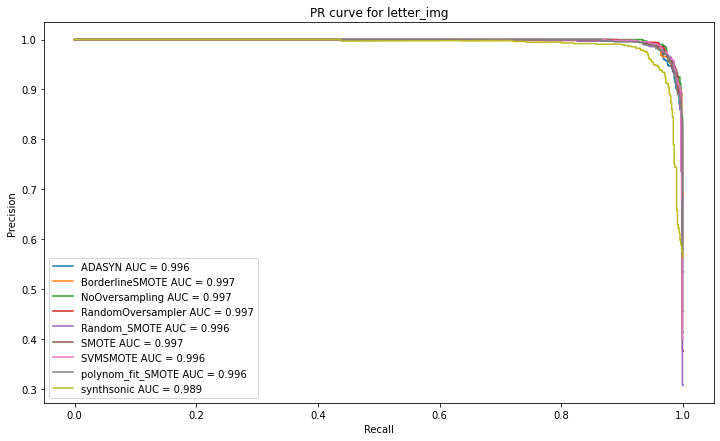

In [13]:
plot_pr(name, letter_prs, letter_recs, letter_aucs, oversampler_names)

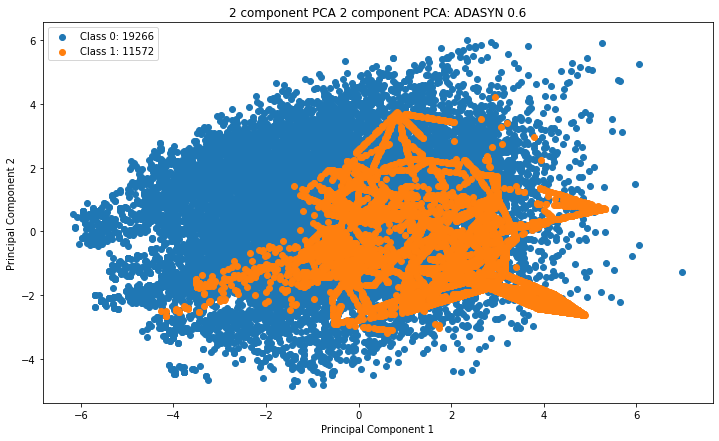

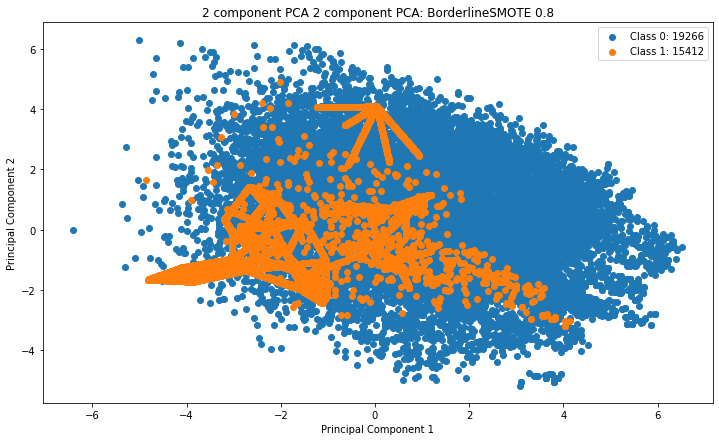

2021-08-30 11:50:47,810:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:50:47,810:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


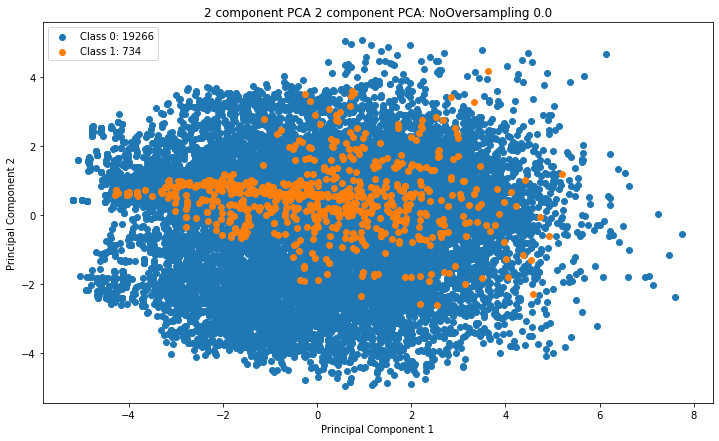

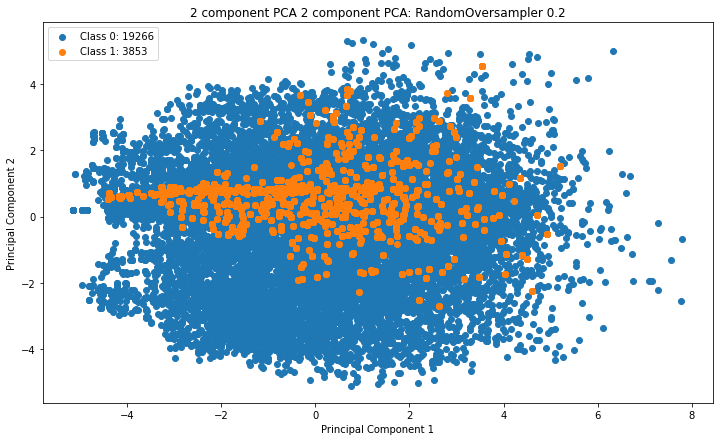

2021-08-30 11:50:48,481:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 11:50:48,481:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


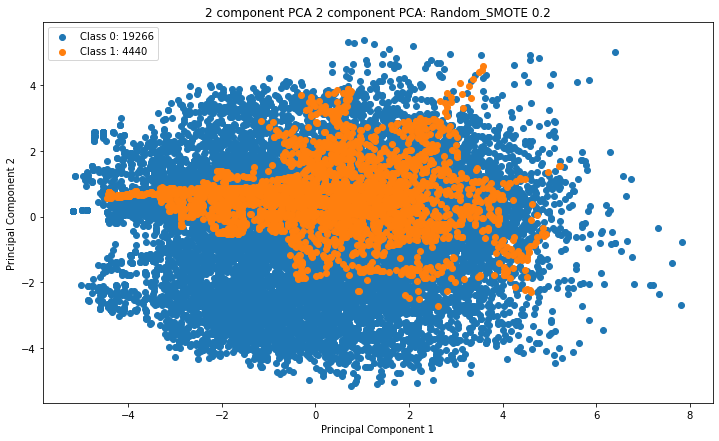

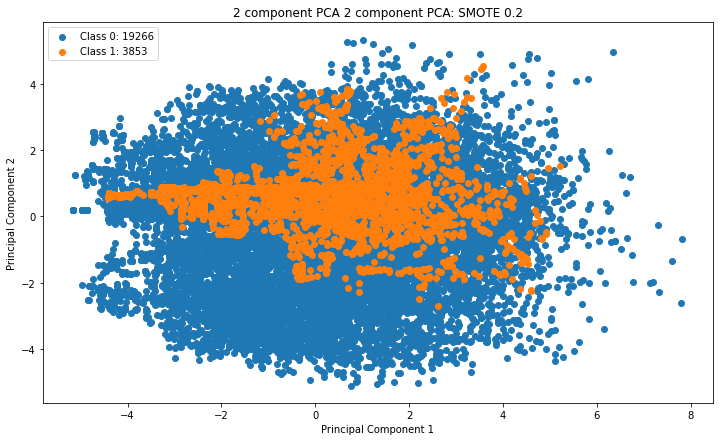

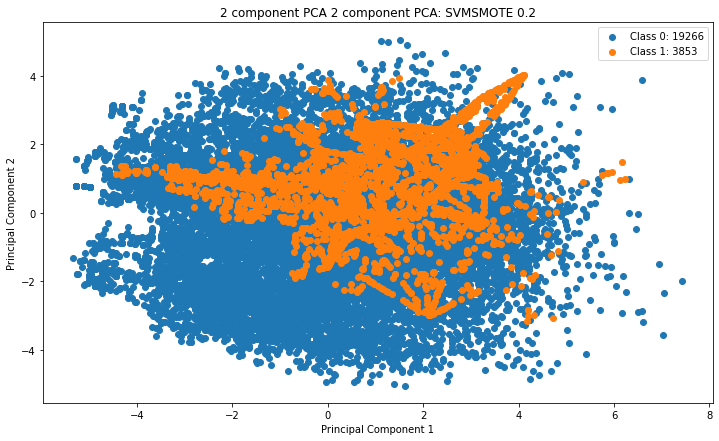

2021-08-30 11:50:50,776:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': 5}")
2021-08-30 11:50:50,776:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': 5}")


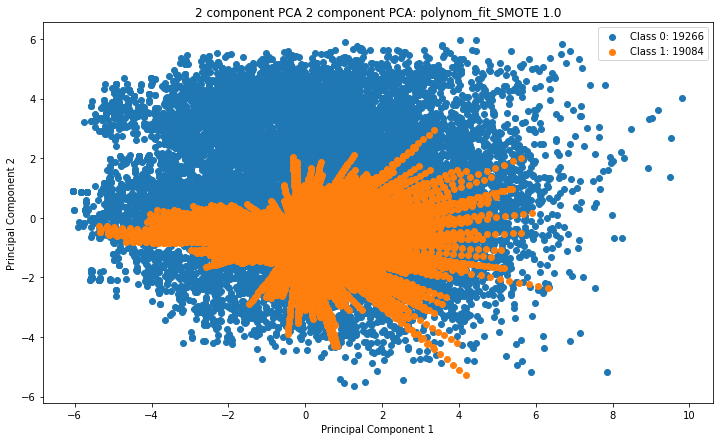

2021-08-30 11:50:51,391:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-30 11:50:51,391:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
Building tree: 100%|██████████| 105/105.0 [00:00<00:00, 869.50it/s]
Generating for node: 4:  12%|█▎        | 2/16 [00:00<00:02,  6.10it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 2: 100%|██████████| 16/16 [00:00<00:00, 40.36it/s] 


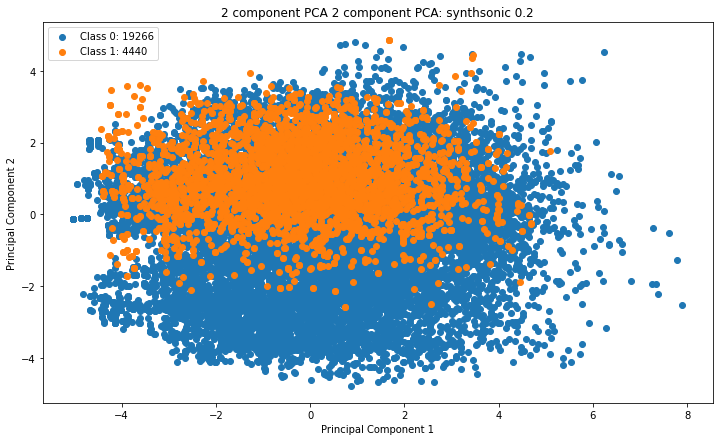

In [33]:
plot_pcas(X,y,oversamplers, oversampler_names,props)

# yeast

In [30]:
X,y,name = HD.load_data('yeast_ml8')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [14]:
yeast_prs, yeast_recs, yeast_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-26 18:59:40,065:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:59:40,065:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:59:40,472:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:59:40,472:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:59:40,874:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:59:40,874:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:59:41,277:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:59:41,277:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 18:59:43,564:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 18:59:43,564:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 18:59:44,536:INFO:Random_SMOTE: Running sampling via ('Random_SMO

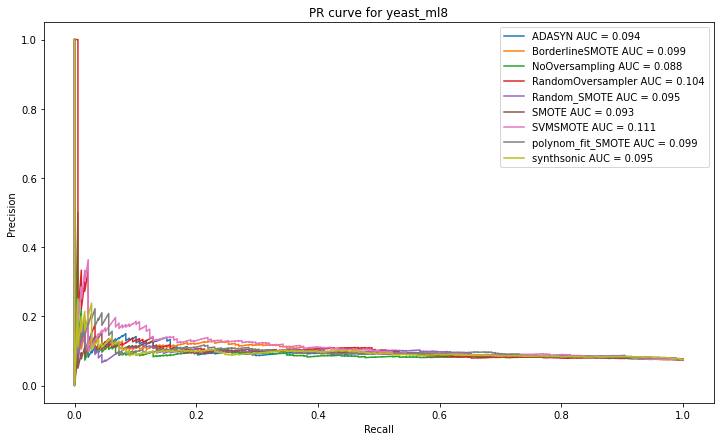

In [15]:
plot_pr(name, yeast_prs, yeast_recs, yeast_aucs, oversampler_names)

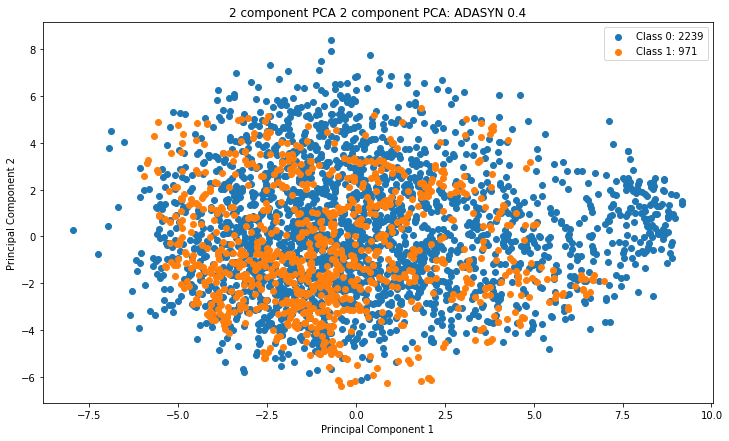

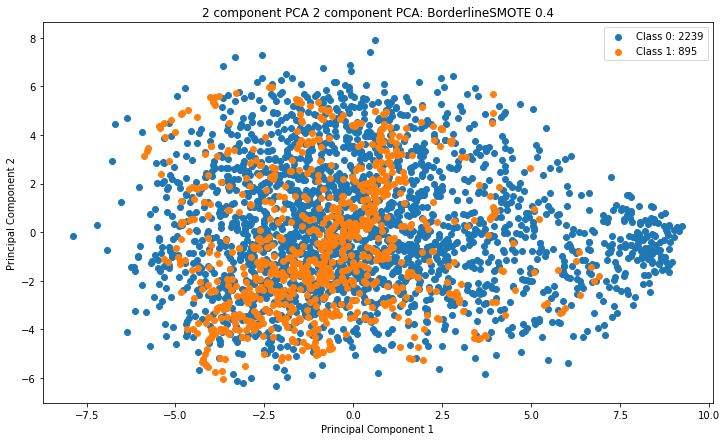

2021-08-30 11:49:18,757:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:49:18,757:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


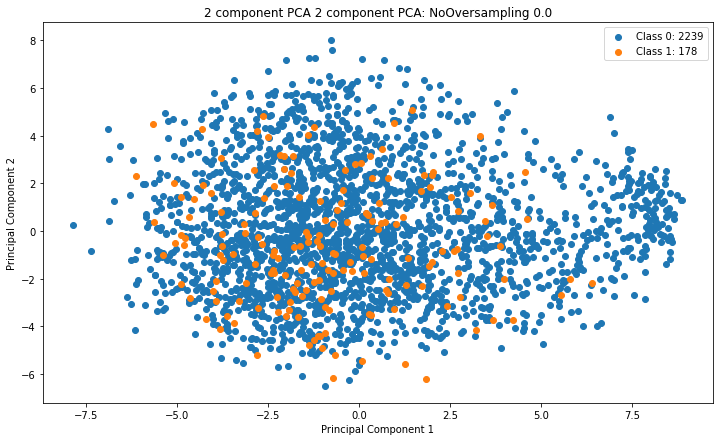

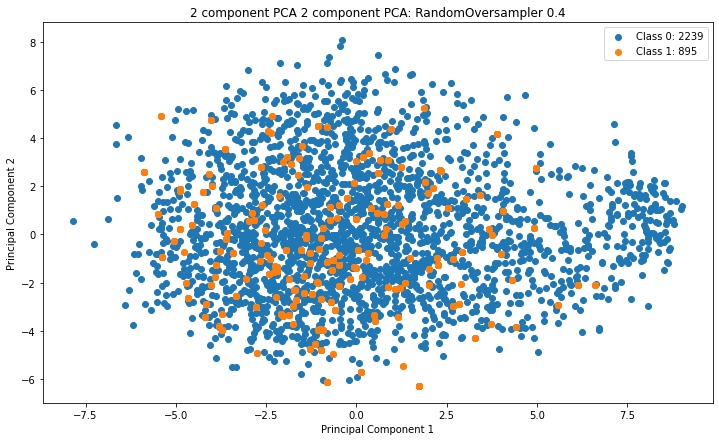

2021-08-30 11:49:19,152:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 11:49:19,152:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


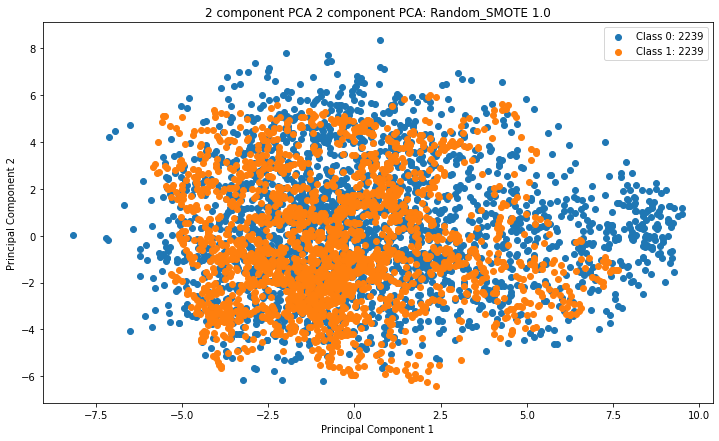

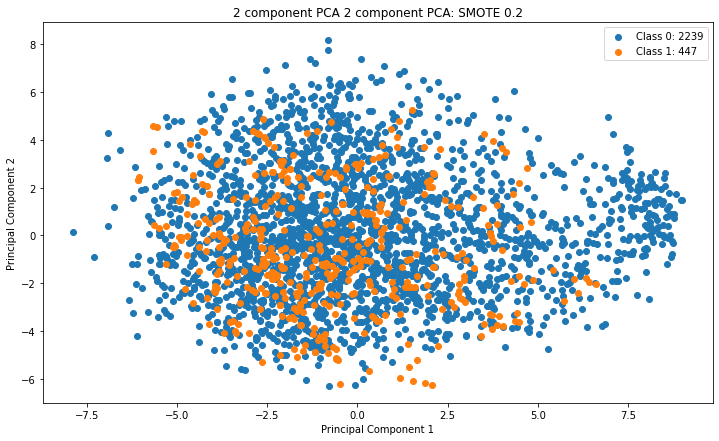

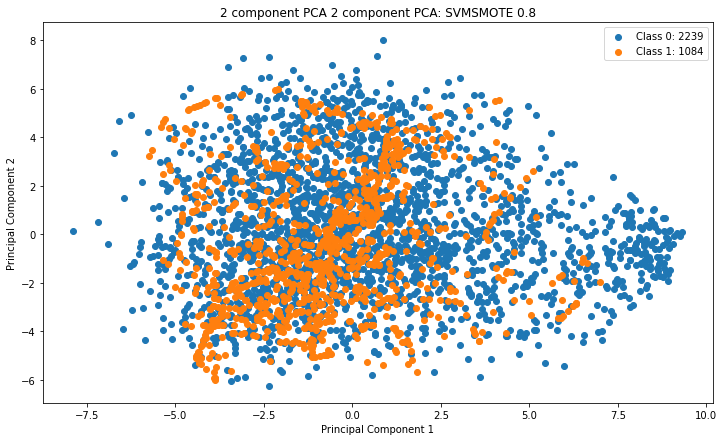

2021-08-30 11:49:20,645:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")
2021-08-30 11:49:20,645:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")


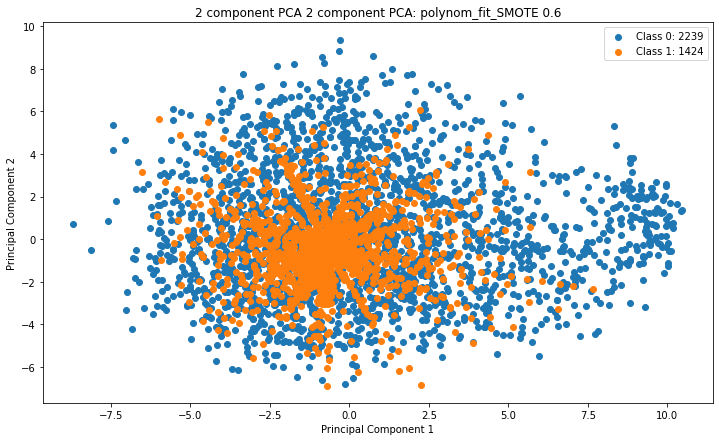

2021-08-30 11:49:20,897:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-30 11:49:20,897:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (178). n_quantiles is set to num samples.
Building tree: 100%|██████████| 5151/5151.0 [00:05<00:00, 865.11it/s]
Generating for node: 5: 100%|██████████| 103/103 [00:07<00:00, 13.83it/s] 


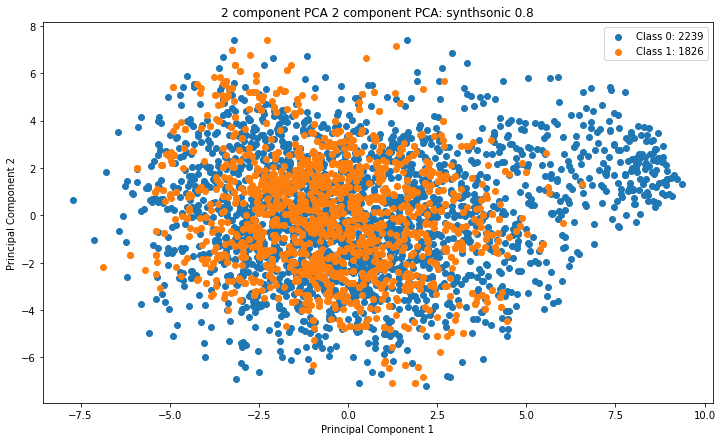

In [31]:
plot_pcas(X,y,oversamplers, oversampler_names,props)

In [25]:
# Examining performance of XGBoost
X,y,name = HD.load_data('yeast_ml8')
CV.loop_over_oversamplers(X,y, name, oversamplers, np.array([0.2,0.4,0.6,0.8,1]))

oversampler:  11%|█         | 1/9 [00:18<02:30, 18.77s/it]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
oversampler:  22%|██▏       | 2/9 [00:35<02:03, 17.70s/it]2021-08-26 22:41:54,677:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 22:41:54,677:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2021-08-26 22:41:55,132:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 22:41:55,132:INFO:NoSMOT

2021-08-26 22:42:16,836:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 22:42:16,836:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 22:42:17,480:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 22:42:17,480:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 22:42:18,131:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 22:42:18,131:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 22:42:18,904:INFO:Random_SMOTE: Running sampling via ('Random_SMO

2021-08-26 22:43:17,136:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")
2021-08-26 22:43:17,873:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")
2021-08-26 22:43:17,873:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")
2021-08-26 22:43:18,657:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")
2021-08-26 22:43:18,657:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")
2021-08-26 22:43:19,489:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6, 'topology': 'star', 'random_state': 5}")
2021-08-26 22:43:19,489:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit

Generating for node: 92: 100%|██████████| 103/103 [00:34<00:00,  3.00it/s]

Generating for node: 30:  75%|███████▍  | 77/103 [00:05<00:01, 13.51it/s]


Generating for node: 92: 100%|██████████| 103/103 [00:07<00:00, 13.89it/s]
2021-08-26 22:44:35,560:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:44:35,560:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 96/5151.0 [00:00<00:05, 871.47it/s]
Building tree:   4%|▍         | 204/5151.0 [00:00<00:05, 924.87it/s]
Building tree:   6%|▌         | 312/5151.0 [00:00<00:05, 942.96it/s]
Building tree:   8%|▊         | 408/5151.0 [00:00<00:05, 942.98it/s]
Building tree:  10%|▉         | 504/5151.0 [00:00<00:04, 945.92it/s]
Building tree:  12%|█▏        | 612/5151.0 [00:00<00:04, 

Generating for node: 11: 100%|██████████| 103/103 [00:34<00:00,  3.03it/s]

Generating for node: 2:  81%|████████  | 83/103 [00:06<00:01, 12.97it/s] 


Generating for node: 11: 100%|██████████| 103/103 [00:07<00:00, 13.59it/s]
2021-08-26 22:45:42,355:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:45:42,355:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 832.06it/s]
Building tree:   3%|▎         | 180/5151.0 [00:00<00:05, 896.79it/s]
Building tree:   6%|▌         | 288/5151.0 [00:00<00:05, 921.33it/s]
Building tree:   8%|▊         | 396/5151.0 [00:00<00:05, 943.98it/s]
Building tree:  10%|▉         | 492/5151.0 [00:00<00:04, 937.33it/s]
Building tree:  11%|█▏        | 588/5151.0 [00:00<00:04, 

Generating for node: 18: 100%|██████████| 103/103 [00:34<00:00,  2.98it/s]

Generating for node: 83:  88%|████████▊ | 91/103 [00:06<00:00, 13.44it/s]


Generating for node: 18: 100%|██████████| 103/103 [00:07<00:00, 13.33it/s]
2021-08-26 22:46:49,536:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:46:49,536:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 834.46it/s]
Building tree:   3%|▎         | 180/5151.0 [00:00<00:05, 900.29it/s]
Building tree:   6%|▌         | 288/5151.0 [00:00<00:05, 958.81it/s]
Building tree:   8%|▊         | 396/5151.0 [00:00<00:04, 962.27it/s]
Building tree:  10%|▉         | 501/5151.0 [00:00<00:04, 992.63it/s]
Building tree:  12%|█▏        | 601/5151.0 [00:00<00:04, 

Generating for node: 33: 100%|██████████| 103/103 [00:33<00:00,  3.05it/s]

Generating for node: 65:  94%|█████████▍| 97/103 [00:07<00:00, 13.54it/s]


Generating for node: 33: 100%|██████████| 103/103 [00:07<00:00, 13.62it/s]
2021-08-26 22:47:55,974:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:47:55,974:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 827.76it/s]
Building tree:   4%|▎         | 192/5151.0 [00:00<00:05, 923.53it/s]
Building tree:   6%|▌         | 300/5151.0 [00:00<00:05, 951.51it/s]
Building tree:   8%|▊         | 408/5151.0 [00:00<00:04, 955.74it/s]
Building tree:  10%|▉         | 504/5151.0 [00:00<00:04, 957.13it/s]
Building tree:  12%|█▏        | 600/5151.0 [00:00<00:04, 

Generating for node: 92: 100%|██████████| 103/103 [00:34<00:00,  3.02it/s]

Generating for node: 92: 100%|██████████| 103/103 [00:07<00:00, 13.87it/s]
2021-08-26 22:49:02,683:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:49:02,683:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")


n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 96/5151.0 [00:00<00:05, 861.89it/s]
Building tree:   4%|▎         | 192/5151.0 [00:00<00:05, 905.21it/s]
Building tree:   6%|▌         | 288/5151.0 [00:00<00:05, 927.68it/s]
Building tree:   7%|▋         | 384/5151.0 [00:00<00:05, 932.95it/s]
Building tree:   9%|▉         | 480/5151.0 [00:00<00:04, 942.25it/s]
Building tree:  11%|█▏        | 588/5151.0 [00:00<00:04, 950.35it/s]
Building tree:  14%|█▎        | 696/5151.0 [00:00<00:04, 966.30it/s]
Building tree:  15%|█▌        | 793/5151.0 [00:00<00:04, 922.73it/s]
Building tree:  17%|█▋        | 888/5151.0 [00:00<00:04, 924.92it/s]
Building tree:  19%|█▉        | 991/5151.0 [00:01<00:04, 955.76it/s]
Building tree:  21%|██        | 1087/5151.0 [00:01<00:04, 946.76it/s]
Building tree:  23%|██▎       | 118

Generating for node: 11: 100%|██████████| 103/103 [00:33<00:00,  3.04it/s]

Generating for node: 11: 100%|██████████| 103/103 [00:07<00:00, 13.86it/s]
2021-08-26 22:50:08,873:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:50:08,873:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 96/5151.0 [00:00<00:05, 863.96it/s]
Building tree:   4%|▎         | 192/5151.0 [00:00<00:05, 911.23it/s]
Building tree:   6%|▌         | 288/5151.0 [00:00<00:05, 914.35it/s]
Building tree:   8%|▊         | 396/5151.0 [00:00<00:04, 952.68it/s]
Building tree:  10%|▉         | 492/5151.0 [00:00<

Building tree:  17%|█▋        | 901/5151.0 [00:00<00:04, 961.93it/s]
Building tree:  20%|█▉        | 1008/5151.0 [00:01<00:04, 963.03it/s]
Building tree:  22%|██▏       | 1116/5151.0 [00:01<00:04, 964.17it/s]
Building tree:  24%|██▍       | 1224/5151.0 [00:01<00:04, 974.27it/s]
Building tree:  26%|██▌       | 1326/5151.0 [00:01<00:03, 987.33it/s]
Building tree:  28%|██▊       | 1425/5151.0 [00:01<00:03, 984.34it/s]
Building tree:  30%|██▉       | 1524/5151.0 [00:01<00:03, 947.50it/s]
Building tree:  32%|███▏      | 1632/5151.0 [00:01<00:03, 953.34it/s]
Building tree:  34%|███▍      | 1740/5151.0 [00:01<00:03, 958.05it/s]
Building tree:  36%|███▌      | 1836/5151.0 [00:01<00:03, 956.27it/s]
Building tree:  38%|███▊      | 1932/5151.0 [00:02<00:03, 955.67it/s]
Building tree:  39%|███▉      | 2028/5151.0 [00:02<00:03, 954.51it/s]
Building tree:  41%|████      | 2124/5151.0 [00:02<00:03, 944.32it/s]
Building tree:  43%|████▎     | 2232/5151.0 [00:02<00:03, 952.06it/s]
Building tree:  45%|█

Generating for node: 18: 100%|██████████| 103/103 [00:33<00:00,  3.04it/s]

Generating for node: 18: 100%|██████████| 103/103 [00:07<00:00, 13.51it/s]
2021-08-26 22:51:15,364:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:51:15,364:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 96/5151.0 [00:00<00:05, 867.40it/s]
Building tree:   4%|▎         | 193/5151.0 [00:00<00:05, 925.14it/s]
Building tree:   6%|▌         | 288/5151.0 [00:00<00:05, 921.37it/s]
Building tree:   8%|▊         | 396/5151.0 [00:00<00:05, 950.96it/s]
Building tree:  10%|▉         | 492/5151.0 [00:00<

Building tree:  39%|███▉      | 2006/5151.0 [00:02<00:03, 966.14it/s]
Building tree:  41%|████      | 2103/5151.0 [00:02<00:03, 964.72it/s]
Building tree:  43%|████▎     | 2200/5151.0 [00:02<00:03, 932.77it/s]
Building tree:  45%|████▍     | 2294/5151.0 [00:02<00:03, 865.18it/s]
Building tree:  46%|████▌     | 2382/5151.0 [00:02<00:03, 868.32it/s]
Building tree:  48%|████▊     | 2470/5151.0 [00:02<00:03, 824.62it/s]
Building tree:  50%|████▉     | 2555/5151.0 [00:02<00:03, 831.60it/s]
Building tree:  51%|█████     | 2639/5151.0 [00:02<00:03, 831.29it/s]
Building tree:  53%|█████▎    | 2724/5151.0 [00:02<00:02, 832.18it/s]
Building tree:  55%|█████▍    | 2820/5151.0 [00:03<00:02, 859.68it/s]
Building tree:  57%|█████▋    | 2916/5151.0 [00:03<00:02, 878.98it/s]
Building tree:  58%|█████▊    | 3012/5151.0 [00:03<00:02, 882.75it/s]
Building tree:  61%|██████    | 3120/5151.0 [00:03<00:02, 913.38it/s]
Building tree:  62%|██████▏   | 3216/5151.0 [00:03<00:02, 924.50it/s]
Building tree:  64%|

Generating for node: 33: 100%|██████████| 103/103 [00:39<00:00,  2.64it/s]

Generating for node: 33: 100%|██████████| 103/103 [00:08<00:00, 12.00it/s]
2021-08-26 22:52:30,659:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:52:30,659:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 834.15it/s]
Building tree:   3%|▎         | 168/5151.0 [00:00<00:06, 823.22it/s]
Building tree:   5%|▍         | 252/5151.0 [00:00<00:05, 828.04it/s]
Building tree:   7%|▋         | 336/5151.0 [00:00<00:05, 815.60it/s]
Building tree:   8%|▊         | 420/5151.0 [00:00<

Building tree:  46%|████▌     | 2376/5151.0 [00:02<00:03, 812.22it/s]
Building tree:  48%|████▊     | 2458/5151.0 [00:03<00:03, 796.35it/s]
Building tree:  49%|████▉     | 2538/5151.0 [00:03<00:03, 785.09it/s]
Building tree:  51%|█████     | 2617/5151.0 [00:03<00:03, 777.65it/s]
Building tree:  52%|█████▏    | 2700/5151.0 [00:03<00:03, 779.51it/s]
Building tree:  54%|█████▍    | 2796/5151.0 [00:03<00:02, 822.78it/s]
Building tree:  56%|█████▌    | 2880/5151.0 [00:03<00:02, 812.96it/s]
Building tree:  58%|█████▊    | 2964/5151.0 [00:03<00:02, 811.06it/s]
Building tree:  59%|█████▉    | 3046/5151.0 [00:03<00:02, 791.35it/s]
Building tree:  61%|██████    | 3126/5151.0 [00:03<00:02, 781.98it/s]
Building tree:  62%|██████▏   | 3216/5151.0 [00:04<00:02, 803.29it/s]
Building tree:  64%|██████▍   | 3300/5151.0 [00:04<00:02, 786.99it/s]
Building tree:  66%|██████▌   | 3384/5151.0 [00:04<00:02, 801.42it/s]
Building tree:  67%|██████▋   | 3468/5151.0 [00:04<00:02, 792.85it/s]
Building tree:  69%|

Generating for node: 92: 100%|██████████| 103/103 [00:42<00:00,  2.45it/s]

Generating for node: 92: 100%|██████████| 103/103 [00:09<00:00, 10.58it/s] 
2021-08-26 22:53:52,476:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:53:52,476:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   1%|          | 60/5151.0 [00:00<00:09, 527.23it/s]
Building tree:   2%|▏         | 113/5151.0 [00:00<00:10, 478.70it/s]
Building tree:   3%|▎         | 180/5151.0 [00:00<00:09, 508.25it/s]
Building tree:   5%|▍         | 240/5151.0 [00:00<00:09, 497.60it/s]
Building tree:   6%|▌         | 312/5151.0 [00:00

Building tree:  25%|██▌       | 1296/5151.0 [00:02<00:05, 752.99it/s]
Building tree:  27%|██▋       | 1380/5151.0 [00:02<00:04, 760.32it/s]
Building tree:  28%|██▊       | 1457/5151.0 [00:02<00:05, 729.85it/s]
Building tree:  30%|██▉       | 1531/5151.0 [00:02<00:05, 709.22it/s]
Building tree:  31%|███       | 1603/5151.0 [00:02<00:05, 668.60it/s]
Building tree:  33%|███▎      | 1680/5151.0 [00:02<00:05, 669.70it/s]
Building tree:  34%|███▍      | 1752/5151.0 [00:02<00:05, 655.48it/s]
Building tree:  35%|███▌      | 1824/5151.0 [00:02<00:05, 655.89it/s]
Building tree:  37%|███▋      | 1896/5151.0 [00:02<00:05, 637.13it/s]
Building tree:  38%|███▊      | 1968/5151.0 [00:03<00:04, 647.23it/s]
Building tree:  40%|███▉      | 2040/5151.0 [00:03<00:04, 642.68it/s]
Building tree:  41%|████      | 2112/5151.0 [00:03<00:04, 644.36it/s]
Building tree:  42%|████▏     | 2184/5151.0 [00:03<00:04, 653.89it/s]
Building tree:  44%|████▍     | 2256/5151.0 [00:03<00:04, 648.66it/s]
Building tree:  45%|

Generating for node: 11: 100%|██████████| 103/103 [00:46<00:00,  2.20it/s]

Generating for node: 11: 100%|██████████| 103/103 [00:08<00:00, 11.91it/s]
2021-08-26 22:55:23,943:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:55:23,943:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 834.01it/s]
Building tree:   3%|▎         | 168/5151.0 [00:00<00:05, 830.86it/s]
Building tree:   5%|▍         | 252/5151.0 [00:00<00:06, 812.06it/s]


Building tree:   7%|▋         | 336/5151.0 [00:00<00:05, 809.22it/s]
Building tree:   8%|▊         | 420/5151.0 [00:00<00:05, 801.61it/s]
Building tree:  10%|▉         | 504/5151.0 [00:00<00:05, 779.65it/s]
Building tree:  11%|█▏        | 588/5151.0 [00:00<00:05, 772.45it/s]
Building tree:  13%|█▎        | 684/5151.0 [00:00<00:05, 793.48it/s]
Building tree:  15%|█▍        | 768/5151.0 [00:00<00:05, 797.64it/s]
Building tree:  17%|█▋        | 852/5151.0 [00:01<00:05, 787.45it/s]
Building tree:  18%|█▊        | 936/5151.0 [00:01<00:05, 786.79it/s]
Building tree:  20%|█▉        | 1020/5151.0 [00:01<00:05, 783.88it/s]
Building tree:  21%|██▏       | 1104/5151.0 [00:01<00:05, 787.59it/s]
Building tree:  23%|██▎       | 1188/5151.0 [00:01<00:05, 790.03it/s]
Building tree:  25%|██▍       | 1268/5151.0 [00:01<00:05, 765.74it/s]
Building tree:  26%|██▌       | 1345/5151.0 [00:01<00:05, 758.29it/s]
Building tree:  28%|██▊       | 1428/5151.0 [00:01<00:04, 759.72it/s]
Building tree:  29%|██▉     

Generating for node: 18: 100%|██████████| 103/103 [00:43<00:00,  2.36it/s]

Generating for node: 18: 100%|██████████| 103/103 [00:08<00:00, 11.78it/s]
2021-08-26 22:56:46,325:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:56:46,325:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 826.44it/s]
Building tree:   3%|▎         | 168/5151.0 [00:00<00:06, 816.97it/s]
Building tree:   5%|▍         | 250/5151.0 [00:00<00:06, 806.75it/s]
Building tree:   6%|▋         | 331/5151.0 [00:00<00:06, 737.98it/s]


Building tree:   8%|▊         | 420/5151.0 [00:00<00:06, 756.75it/s]
Building tree:  10%|▉         | 504/5151.0 [00:00<00:05, 781.06it/s]
Building tree:  11%|█▏        | 588/5151.0 [00:00<00:05, 792.06it/s]
Building tree:  13%|█▎        | 672/5151.0 [00:00<00:05, 800.49it/s]
Building tree:  15%|█▍        | 756/5151.0 [00:00<00:05, 802.85it/s]
Building tree:  17%|█▋        | 852/5151.0 [00:01<00:05, 823.16it/s]
Building tree:  18%|█▊        | 936/5151.0 [00:01<00:05, 826.64it/s]
Building tree:  20%|█▉        | 1020/5151.0 [00:01<00:05, 824.88it/s]
Building tree:  21%|██▏       | 1104/5151.0 [00:01<00:04, 824.95it/s]
Building tree:  23%|██▎       | 1188/5151.0 [00:01<00:04, 827.70it/s]
Building tree:  25%|██▍       | 1272/5151.0 [00:01<00:04, 824.73it/s]
Building tree:  26%|██▋       | 1357/5151.0 [00:01<00:04, 832.18it/s]
Building tree:  28%|██▊       | 1441/5151.0 [00:01<00:04, 784.33it/s]
Building tree:  30%|██▉       | 1536/5151.0 [00:01<00:04, 807.44it/s]
Building tree:  31%|███▏   

Generating for node: 33: 100%|██████████| 103/103 [00:37<00:00,  2.75it/s]

Generating for node: 33: 100%|██████████| 103/103 [00:07<00:00, 13.56it/s]
2021-08-26 22:58:01,414:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:58:01,414:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 96/5151.0 [00:00<00:05, 852.46it/s]
Building tree:   4%|▍         | 204/5151.0 [00:00<00:05, 905.85it/s]
Building tree:   6%|▌         | 312/5151.0 [00:00<00:05, 953.56it/s]
Building tree:   8%|▊         | 420/5151.0 [00:00<00:04, 950.79it/s]
Building tree:  10%|█         | 516/5151.0 [00:00<

Building tree:  14%|█▎        | 706/5151.0 [00:00<00:04, 920.66it/s]
Building tree:  16%|█▌        | 799/5151.0 [00:00<00:04, 918.97it/s]
Building tree:  17%|█▋        | 891/5151.0 [00:00<00:04, 907.42it/s]
Building tree:  19%|█▉        | 984/5151.0 [00:01<00:04, 910.47it/s]
Building tree:  21%|██        | 1080/5151.0 [00:01<00:04, 923.50it/s]
Building tree:  23%|██▎       | 1176/5151.0 [00:01<00:04, 926.71it/s]
Building tree:  25%|██▍       | 1272/5151.0 [00:01<00:04, 930.94it/s]
Building tree:  27%|██▋       | 1368/5151.0 [00:01<00:04, 930.29it/s]
Building tree:  29%|██▉       | 1488/5151.0 [00:01<00:03, 973.68it/s]
Building tree:  31%|███       | 1586/5151.0 [00:01<00:03, 940.26it/s]
Building tree:  33%|███▎      | 1680/5151.0 [00:01<00:03, 936.45it/s]
Building tree:  34%|███▍      | 1776/5151.0 [00:01<00:03, 938.05it/s]
Building tree:  36%|███▋      | 1872/5151.0 [00:02<00:03, 935.80it/s]
Building tree:  38%|███▊      | 1968/5151.0 [00:02<00:03, 934.74it/s]
Building tree:  40%|████

Generating for node: 92: 100%|██████████| 103/103 [00:34<00:00,  2.98it/s]

Generating for node: 92: 100%|██████████| 103/103 [00:07<00:00, 13.95it/s]
2021-08-26 22:59:08,861:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 22:59:08,861:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 818.31it/s]
Building tree:   3%|▎         | 180/5151.0 [00:00<00:05, 899.67it/s]
Building tree:   6%|▌         | 288/5151.0 [00:00<00:05, 937.45it/s]
Building tree:   7%|▋         | 384/5151.0 [00:00<00:05, 933.47it/s]
Building tree:   9%|▉         | 480/5151.0 [00:00<

Building tree:  33%|███▎      | 1680/5151.0 [00:01<00:03, 973.08it/s]
Building tree:  35%|███▍      | 1788/5151.0 [00:01<00:03, 974.25it/s]
Building tree:  37%|███▋      | 1892/5151.0 [00:02<00:03, 992.91it/s]
Building tree:  39%|███▊      | 1992/5151.0 [00:02<00:03, 917.11it/s]
Building tree:  41%|████      | 2100/5151.0 [00:02<00:03, 930.04it/s]
Building tree:  43%|████▎     | 2208/5151.0 [00:02<00:03, 937.25it/s]
Building tree:  45%|████▍     | 2316/5151.0 [00:02<00:02, 955.32it/s]
Building tree:  47%|████▋     | 2412/5151.0 [00:02<00:02, 949.94it/s]
Building tree:  49%|████▊     | 2508/5151.0 [00:02<00:02, 919.63it/s]
Building tree:  51%|█████     | 2616/5151.0 [00:02<00:02, 929.73it/s]
Building tree:  53%|█████▎    | 2736/5151.0 [00:02<00:02, 969.73it/s]
Building tree:  55%|█████▌    | 2844/5151.0 [00:03<00:02, 985.60it/s]
Building tree:  57%|█████▋    | 2943/5151.0 [00:03<00:02, 975.98it/s]
Building tree:  59%|█████▉    | 3048/5151.0 [00:03<00:02, 982.50it/s]
Building tree:  61%|

Generating for node: 11: 100%|██████████| 103/103 [00:34<00:00,  2.97it/s]

Generating for node: 11: 100%|██████████| 103/103 [00:07<00:00, 13.25it/s]
2021-08-26 23:00:17,074:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 23:00:17,074:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 826.17it/s]
Building tree:   3%|▎         | 167/5151.0 [00:00<00:07, 656.79it/s]
Building tree:   5%|▍         | 235/5151.0 [00:00<00:08, 589.07it/s]
Building tree:   6%|▋         | 324/5151.0 [00:00<00:07, 687.03it/s]
Building tree:   8%|▊         | 396/5151.0 [00:00<

Building tree:  50%|█████     | 2580/5151.0 [00:03<00:03, 778.29it/s]
Building tree:  52%|█████▏    | 2676/5151.0 [00:03<00:03, 816.51it/s]
Building tree:  54%|█████▍    | 2772/5151.0 [00:03<00:02, 848.92it/s]
Building tree:  56%|█████▌    | 2868/5151.0 [00:03<00:02, 878.27it/s]
Building tree:  58%|█████▊    | 2976/5151.0 [00:03<00:02, 932.94it/s]
Building tree:  60%|█████▉    | 3073/5151.0 [00:03<00:02, 934.69it/s]
Building tree:  62%|██████▏   | 3180/5151.0 [00:03<00:02, 950.74it/s]
Building tree:  64%|██████▍   | 3288/5151.0 [00:03<00:01, 969.58it/s]
Building tree:  66%|██████▌   | 3396/5151.0 [00:03<00:01, 971.74it/s]
Building tree:  68%|██████▊   | 3504/5151.0 [00:04<00:01, 972.59it/s]
Building tree:  70%|███████   | 3612/5151.0 [00:04<00:01, 953.75it/s]
Building tree:  72%|███████▏  | 3720/5151.0 [00:04<00:01, 983.80it/s]
Building tree:  74%|███████▍  | 3819/5151.0 [00:04<00:01, 943.61it/s]
Building tree:  76%|███████▌  | 3914/5151.0 [00:04<00:01, 935.04it/s]
Building tree:  78%|

Generating for node: 18: 100%|██████████| 103/103 [00:37<00:00,  2.72it/s]

Generating for node: 18: 100%|██████████| 103/103 [00:09<00:00, 11.14it/s]
2021-08-26 23:01:31,345:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 23:01:31,345:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 838.24it/s]
Building tree:   3%|▎         | 168/5151.0 [00:00<00:09, 499.56it/s]
Building tree:   5%|▌         | 270/5151.0 [00:00<00:07, 672.94it/s]
Building tree:   7%|▋         | 360/5151.0 [00:00<00:06, 742.84it/s]
Building tree:   9%|▉         | 468/5151.0 [00:00<

Building tree:  61%|██████    | 3120/5151.0 [00:04<00:05, 371.35it/s]
Building tree:  62%|██████▏   | 3180/5151.0 [00:04<00:04, 412.70it/s]
Building tree:  63%|██████▎   | 3240/5151.0 [00:04<00:04, 452.03it/s]
Building tree:  64%|██████▍   | 3300/5151.0 [00:04<00:03, 482.78it/s]
Building tree:  65%|██████▌   | 3372/5151.0 [00:05<00:03, 514.17it/s]
Building tree:  67%|██████▋   | 3444/5151.0 [00:05<00:03, 558.84it/s]
Building tree:  68%|██████▊   | 3504/5151.0 [00:05<00:02, 568.39it/s]
Building tree:  69%|██████▉   | 3564/5151.0 [00:05<00:02, 564.24it/s]
Building tree:  70%|███████   | 3622/5151.0 [00:05<00:02, 559.24it/s]
Building tree:  72%|███████▏  | 3684/5151.0 [00:05<00:02, 548.20it/s]
Building tree:  73%|███████▎  | 3756/5151.0 [00:05<00:02, 574.27it/s]
Building tree:  74%|███████▍  | 3816/5151.0 [00:05<00:02, 579.94it/s]
Building tree:  75%|███████▌  | 3888/5151.0 [00:05<00:02, 587.87it/s]
Building tree:  77%|███████▋  | 3960/5151.0 [00:06<00:02, 540.50it/s]
Building tree:  78%|

Generating for node: 33: 100%|██████████| 103/103 [00:38<00:00,  2.70it/s]

Generating for node: 33: 100%|██████████| 103/103 [00:07<00:00, 13.20it/s]
2021-08-26 23:02:50,896:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 23:02:50,896:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   1%|▏         | 72/5151.0 [00:00<00:08, 632.62it/s]
Building tree:   3%|▎         | 136/5151.0 [00:00<00:07, 635.34it/s]
Building tree:   4%|▍         | 200/5151.0 [00:00<00:07, 636.70it/s]
Building tree:   5%|▌         | 264/5151.0 [00:00<00:08, 596.68it/s]
Building tree:   6%|▋         | 324/5151.0 [00:00<

Building tree:  42%|████▏     | 2160/5151.0 [00:03<00:05, 583.53it/s]
Building tree:  43%|████▎     | 2220/5151.0 [00:03<00:05, 566.82it/s]
Building tree:  44%|████▍     | 2280/5151.0 [00:04<00:05, 549.39it/s]
Building tree:  45%|████▌     | 2340/5151.0 [00:04<00:05, 555.96it/s]
Building tree:  47%|████▋     | 2412/5151.0 [00:04<00:04, 571.97it/s]
Building tree:  48%|████▊     | 2470/5151.0 [00:04<00:04, 564.81it/s]
Building tree:  49%|████▉     | 2532/5151.0 [00:04<00:04, 577.40it/s]
Building tree:  50%|█████     | 2592/5151.0 [00:04<00:04, 583.47it/s]
Building tree:  51%|█████▏    | 2652/5151.0 [00:04<00:04, 576.95it/s]
Building tree:  53%|█████▎    | 2712/5151.0 [00:04<00:04, 580.08it/s]
Building tree:  54%|█████▍    | 2772/5151.0 [00:04<00:04, 579.34it/s]
Building tree:  55%|█████▍    | 2832/5151.0 [00:05<00:04, 579.63it/s]
Building tree:  56%|█████▌    | 2892/5151.0 [00:05<00:03, 583.96it/s]
Building tree:  57%|█████▋    | 2952/5151.0 [00:05<00:03, 582.96it/s]
Building tree:  58%|

Generating for node: 92: 100%|██████████| 103/103 [00:40<00:00,  2.52it/s]

Generating for node: 92: 100%|██████████| 103/103 [00:08<00:00, 12.63it/s]
2021-08-26 23:04:16,873:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 23:04:16,873:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 832.82it/s]
Building tree:   3%|▎         | 180/5151.0 [00:00<00:05, 886.73it/s]
Building tree:   5%|▌         | 276/5151.0 [00:00<00:05, 902.20it/s]
Building tree:   7%|▋         | 372/5151.0 [00:00<00:05, 911.82it/s]
Building tree:   9%|▉         | 468/5151.0 [00:00<

Building tree:  21%|██        | 1056/5151.0 [00:01<00:04, 953.86it/s]
Building tree:  22%|██▏       | 1152/5151.0 [00:01<00:04, 950.92it/s]
Building tree:  24%|██▍       | 1248/5151.0 [00:01<00:04, 950.98it/s]
Building tree:  26%|██▌       | 1344/5151.0 [00:01<00:04, 908.79it/s]
Building tree:  28%|██▊       | 1440/5151.0 [00:01<00:04, 906.69it/s]
Building tree:  30%|██▉       | 1536/5151.0 [00:01<00:04, 898.92it/s]
Building tree:  32%|███▏      | 1632/5151.0 [00:01<00:03, 904.68it/s]
Building tree:  34%|███▎      | 1728/5151.0 [00:01<00:03, 912.23it/s]
Building tree:  36%|███▌      | 1848/5151.0 [00:02<00:03, 962.61it/s]
Building tree:  38%|███▊      | 1945/5151.0 [00:02<00:03, 953.77it/s]
Building tree:  40%|███▉      | 2041/5151.0 [00:02<00:03, 906.56it/s]
Building tree:  42%|████▏     | 2148/5151.0 [00:02<00:03, 940.52it/s]
Building tree:  44%|████▍     | 2256/5151.0 [00:02<00:03, 946.29it/s]
Building tree:  46%|████▌     | 2352/5151.0 [00:02<00:02, 948.08it/s]
Building tree:  48%|

Generating for node: 11: 100%|██████████| 103/103 [00:43<00:00,  2.39it/s]

Generating for node: 11: 100%|██████████| 103/103 [00:08<00:00, 12.59it/s]
2021-08-26 23:05:39,684:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 23:05:39,684:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 812.01it/s]
Building tree:   3%|▎         | 180/5151.0 [00:00<00:05, 857.94it/s]
Building tree:   5%|▌         | 266/5151.0 [00:00<00:05, 856.44it/s]
Building tree:   7%|▋         | 352/5151.0 [00:00<00:05, 844.27it/s]
Building tree:   9%|▊         | 444/5151.0 [00:00<

Building tree:  33%|███▎      | 1716/5151.0 [00:02<00:03, 864.34it/s]
Building tree:  35%|███▌      | 1803/5151.0 [00:02<00:03, 865.49it/s]
Building tree:  37%|███▋      | 1890/5151.0 [00:02<00:03, 864.76it/s]
Building tree:  38%|███▊      | 1980/5151.0 [00:02<00:03, 853.71it/s]
Building tree:  40%|████      | 2076/5151.0 [00:02<00:03, 858.03it/s]
Building tree:  42%|████▏     | 2172/5151.0 [00:02<00:03, 865.72it/s]
Building tree:  44%|████▍     | 2268/5151.0 [00:02<00:03, 863.21it/s]
Building tree:  46%|████▌     | 2355/5151.0 [00:02<00:03, 850.92it/s]
Building tree:  47%|████▋     | 2441/5151.0 [00:02<00:03, 837.66it/s]
Building tree:  49%|████▉     | 2532/5151.0 [00:02<00:03, 835.06it/s]
Building tree:  51%|█████     | 2616/5151.0 [00:03<00:03, 821.29it/s]
Building tree:  52%|█████▏    | 2700/5151.0 [00:03<00:02, 822.51it/s]
Building tree:  54%|█████▍    | 2796/5151.0 [00:03<00:02, 835.86it/s]
Building tree:  56%|█████▌    | 2892/5151.0 [00:03<00:02, 842.12it/s]
Building tree:  58%|

Generating for node: 18: 100%|██████████| 103/103 [00:39<00:00,  2.60it/s]

Generating for node: 18: 100%|██████████| 103/103 [00:09<00:00, 10.69it/s]
2021-08-26 23:06:57,262:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-26 23:06:57,262:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 84/5151.0 [00:00<00:06, 803.84it/s]
Building tree:   3%|▎         | 168/5151.0 [00:00<00:06, 784.79it/s]
Building tree:   5%|▍         | 252/5151.0 [00:00<00:06, 778.22it/s]
Building tree:   7%|▋         | 336/5151.0 [00:00<00:06, 796.49it/s]
Building tree:   8%|▊         | 420/5151.0 [00:00<

Building tree:  42%|████▏     | 2173/5151.0 [00:02<00:03, 839.56it/s]
Building tree:  44%|████▍     | 2257/5151.0 [00:02<00:03, 812.62it/s]
Building tree:  45%|████▌     | 2340/5151.0 [00:02<00:03, 795.27it/s]
Building tree:  47%|████▋     | 2424/5151.0 [00:02<00:03, 799.38it/s]
Building tree:  49%|████▊     | 2505/5151.0 [00:03<00:03, 789.03it/s]
Building tree:  51%|█████     | 2604/5151.0 [00:03<00:03, 817.80it/s]
Building tree:  52%|█████▏    | 2688/5151.0 [00:03<00:03, 813.31it/s]
Building tree:  54%|█████▍    | 2784/5151.0 [00:03<00:02, 815.56it/s]
Building tree:  56%|█████▌    | 2880/5151.0 [00:03<00:02, 833.60it/s]
Building tree:  58%|█████▊    | 2964/5151.0 [00:03<00:02, 821.85it/s]
Building tree:  59%|█████▉    | 3048/5151.0 [00:03<00:02, 806.88it/s]
Building tree:  61%|██████    | 3132/5151.0 [00:03<00:02, 815.61it/s]
Building tree:  63%|██████▎   | 3228/5151.0 [00:03<00:02, 842.39it/s]
Building tree:  65%|██████▍   | 3324/5151.0 [00:04<00:02, 849.54it/s]
Building tree:  66%|

Generating for node: 33: 100%|██████████| 103/103 [00:40<00:00,  2.55it/s]

oversampler: 100%|██████████| 9/9 [26:56<00:00, 179.59s/it]


dataset                                        oversampler  proportion  \
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         0.2   
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         0.4   
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         0.6   
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         0.8   
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         1.0   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         0.2   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         0.4   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         0.6   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         0.8   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         1.0   
0  yeast_ml8                                  ('NoSMOTE', '{}')         0.2   
0  yeast_ml8                                  ('NoSMOTE', '{}')         0.4   
0  yeast_ml8                                  ('NoSMOTE', '{}')         0.6   
0  yeast_ml8                                  ('NoSMOTE', '{}')         0.8   
0  yeast_ml8                                  ('NoSMOTE', '{}')         1.0   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         0.2   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         0.4   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         0.6   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         0.8   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         1.0   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         0.2   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         0.4   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         0.6   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         0.8   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         1.0   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         0.2   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         0.4   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         0.6   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         0.8   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         1.0   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         0.2   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         0.4   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         0.6   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         0.8   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         1.0   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         0.2   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         0.4   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         0.6   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         0.8   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         1.0   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         0.2   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         0.4   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         0.6   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         0.8   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         1.0   

   balanced_accuracy  balanced_accuracy_std    G_mean  G_mean_std        f1  \
0           0.499429               0.004886  0.037101    0.064261  0.009804   
0           0.501475               0.003611  0.111318    0.064272  0.027504   
0           0.497616               0.009530  0.089042    0.091547  0.025653   
0           0.500556               0.004649  0.177937 

In [17]:
# Checking performance with simpler model
X,y,name = HD.load_data('yeast_ml8')
cv_dectree = CrossValidation(clf = DecisionTreeClassifier(random_state=5))
cv_dectree.loop_over_oversamplers(X,y, name, oversamplers, np.array([0.2,0.4,0.6,0.8,1]))

oversampler:  22%|██▏       | 2/9 [00:20<01:11, 10.20s/it]2021-08-27 14:24:48,638:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:48,638:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:48,916:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:48,916:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:49,284:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:49,284:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:49,659:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:49,659:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:49,996:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:49,996:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:50,267:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:50,267:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:24:5

2021-08-27 14:25:04,307:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-27 14:25:04,980:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-27 14:25:04,980:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-27 14:25:05,570:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-27 14:25:05,570:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-27 14:25:06,191:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-27 14:25:06,191:INFO:Random_SMOTE: Running sampling via ('Random_SMO

Generating for node: 99: 100%|██████████| 103/103 [00:35<00:00,  2.86it/s]

Generating for node: 43:  44%|████▎     | 45/103 [00:03<00:04, 14.03it/s]


Generating for node: 99: 100%|██████████| 103/103 [00:07<00:00, 14.04it/s]
2021-08-27 14:26:55,889:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:26:55,889:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 96/5151.0 [00:00<00:05, 890.36it/s]
Building tree:   4%|▎         | 192/5151.0 [00:00<00:05, 893.62it/s]
Building tree:   6%|▌         | 288/5151.0 [00:00<00:05, 900.27it/s]
Building tree:   7%|▋         | 379/5151.0 [00:00<00:05, 887.47it/s]
Building tree:   9%|▉         | 468/5151.0 [00:00<00:05, 845.16it/s]
Building tree:  11%|█         | 553/5151.0 [00:00<00:

Generating for node: 2: 100%|██████████| 103/103 [00:35<00:00,  2.87it/s]

Generating for node: 84:  49%|████▊     | 50/103 [00:04<00:04, 11.82it/s]


Generating for node: 2: 100%|██████████| 103/103 [00:08<00:00, 12.71it/s] 
2021-08-27 14:28:21,973:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:28:21,973:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1028.66it/s]
Building tree:   4%|▍         | 211/5151.0 [00:00<00:05, 972.31it/s] 
Building tree:   6%|▌         | 309/5151.0 [00:00<00:05, 905.30it/s]
Building tree:   8%|▊         | 408/5151.0 [00:00<00:05, 896.80it/s]
Building tree:  10%|█         | 516/5151.0 [00:00<00:04, 937.04it/s]
Building tree:  12%|█▏        | 610/5151.0 [00:00<

Generating for node: 79: 100%|██████████| 103/103 [00:35<00:00,  2.87it/s]

Generating for node: 54:  53%|█████▎    | 55/103 [00:04<00:03, 12.85it/s]


Generating for node: 79: 100%|██████████| 103/103 [00:07<00:00, 13.19it/s]
2021-08-27 14:29:48,397:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:29:48,397:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1032.29it/s]
Building tree:   4%|▍         | 212/5151.0 [00:00<00:04, 1025.39it/s]
Building tree:   6%|▌         | 315/5151.0 [00:00<00:04, 974.31it/s] 
Building tree:   8%|▊         | 420/5151.0 [00:00<00:04, 959.95it/s]
Building tree:  10%|█         | 528/5151.0 [00:00<00:04, 969.31it/s]
Building tree:  12%|█▏        | 626/5151.0 [00:00

Generating for node: 75: 100%|██████████| 103/103 [00:34<00:00,  2.96it/s]

Generating for node: 56:  60%|██████    | 62/103 [00:04<00:03, 12.36it/s]


Generating for node: 75: 100%|██████████| 103/103 [00:07<00:00, 13.23it/s]
2021-08-27 14:31:12,268:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:31:12,268:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:05, 992.68it/s]
Building tree:   4%|▍         | 208/5151.0 [00:00<00:05, 985.57it/s]
Building tree:   6%|▌         | 307/5151.0 [00:00<00:05, 944.87it/s]
Building tree:   8%|▊         | 402/5151.0 [00:00<00:05, 937.19it/s]
Building tree:  10%|▉         | 496/5151.0 [00:00<00:05, 873.55it/s]
Building tree:  11%|█▏        | 588/5151.0 [00:00<00

Generating for node: 99: 100%|██████████| 103/103 [00:36<00:00,  2.84it/s]

Generating for node: 73:  65%|██████▌   | 67/103 [00:04<00:02, 13.87it/s]


Generating for node: 99: 100%|██████████| 103/103 [00:07<00:00, 14.07it/s]
2021-08-27 14:32:37,461:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:32:37,461:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1015.86it/s]
Building tree:   4%|▍         | 210/5151.0 [00:00<00:04, 1014.75it/s]
Building tree:   6%|▌         | 312/5151.0 [00:00<00:05, 964.38it/s] 
Building tree:   8%|▊         | 409/5151.0 [00:00<00:04, 964.17it/s]
Building tree:  10%|▉         | 506/5151.0 [00:00<00:04, 963.65it/s]
Building tree:  12%|█▏        | 603/5151.0 [00:00

Generating for node: 2: 100%|██████████| 103/103 [00:35<00:00,  2.88it/s]

Generating for node: 20:  69%|██████▉   | 71/103 [00:05<00:02, 11.54it/s]


Generating for node: 2: 100%|██████████| 103/103 [00:08<00:00, 12.61it/s]
2021-08-27 14:34:04,309:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:34:04,309:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 106/5151.0 [00:00<00:04, 1059.71it/s]
Building tree:   4%|▍         | 212/5151.0 [00:00<00:05, 980.62it/s] 
Building tree:   6%|▌         | 311/5151.0 [00:00<00:05, 963.48it/s]
Building tree:   8%|▊         | 408/5151.0 [00:00<00:05, 902.58it/s]
Building tree:  10%|▉         | 499/5151.0 [00:00<00:05, 899.93it/s]
Building tree:  11%|█▏        | 590/5151.0 [00:00<0

Generating for node: 79: 100%|██████████| 103/103 [00:35<00:00,  2.89it/s]

Generating for node: 30:  74%|███████▍  | 76/103 [00:05<00:02, 12.93it/s]


Generating for node: 79: 100%|██████████| 103/103 [00:07<00:00, 13.41it/s]
2021-08-27 14:35:30,401:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:35:30,401:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:05, 987.00it/s]
Building tree:   4%|▍         | 207/5151.0 [00:00<00:05, 889.88it/s]
Building tree:   6%|▌         | 300/5151.0 [00:00<00:05, 891.89it/s]
Building tree:   8%|▊         | 396/5151.0 [00:00<00:05, 880.08it/s]
Building tree:  10%|▉         | 492/5151.0 [00:00<00:05, 882.62it/s]
Building tree:  12%|█▏        | 600/5151.0 [00:00<00

Generating for node: 75: 100%|██████████| 103/103 [00:34<00:00,  3.01it/s]

Generating for node: 70:  10%|▉         | 10/103 [00:00<00:06, 14.48it/s]


Generating for node: 75: 100%|██████████| 103/103 [00:07<00:00, 13.16it/s]
2021-08-27 14:36:53,627:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:36:53,627:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1035.74it/s]
Building tree:   4%|▍         | 216/5151.0 [00:00<00:04, 1002.58it/s]
Building tree:   6%|▌         | 317/5151.0 [00:00<00:04, 1001.49it/s]
Building tree:   8%|▊         | 420/5151.0 [00:00<00:04, 968.22it/s] 
Building tree:  10%|█         | 528/5151.0 [00:00<00:04, 968.81it/s]
Building tree:  12%|█▏        | 625/5151.0 [00:0

Generating for node: 99: 100%|██████████| 103/103 [00:35<00:00,  2.90it/s]

Generating for node: 87:  17%|█▋        | 17/103 [00:01<00:06, 14.30it/s]


Generating for node: 99: 100%|██████████| 103/103 [00:07<00:00, 12.90it/s]
2021-08-27 14:38:18,511:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:38:18,511:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1030.27it/s]
Building tree:   4%|▍         | 212/5151.0 [00:00<00:04, 1022.90it/s]
Building tree:   6%|▌         | 315/5151.0 [00:00<00:05, 966.25it/s] 
Building tree:   8%|▊         | 412/5151.0 [00:00<00:04, 964.73it/s]
Building tree:  10%|▉         | 509/5151.0 [00:00<00:04, 960.19it/s]
Building tree:  12%|█▏        | 612/5151.0 [00:00

Generating for node: 2: 100%|██████████| 103/103 [00:33<00:00,  3.06it/s]

Generating for node: 66:  24%|██▍       | 25/103 [00:01<00:05, 13.88it/s]


Generating for node: 2: 100%|██████████| 103/103 [00:07<00:00, 14.00it/s]
2021-08-27 14:39:41,258:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:39:41,258:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1045.99it/s]
Building tree:   4%|▍         | 216/5151.0 [00:00<00:04, 989.75it/s] 
Building tree:   6%|▌         | 316/5151.0 [00:00<00:04, 993.40it/s]
Building tree:   8%|▊         | 416/5151.0 [00:00<00:04, 994.15it/s]
Building tree:  10%|█         | 516/5151.0 [00:00<00:04, 970.21it/s]
Building tree:  12%|█▏        | 614/5151.0 [00:00<0

Generating for node: 79: 100%|██████████| 103/103 [00:33<00:00,  3.08it/s]

Generating for node: 20:  30%|███       | 31/103 [00:02<00:05, 13.65it/s]


Generating for node: 79: 100%|██████████| 103/103 [00:07<00:00, 13.94it/s]
2021-08-27 14:41:01,808:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:41:01,808:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1037.64it/s]
Building tree:   4%|▍         | 212/5151.0 [00:00<00:05, 938.26it/s] 
Building tree:   6%|▌         | 307/5151.0 [00:00<00:05, 922.74it/s]
Building tree:   8%|▊         | 400/5151.0 [00:00<00:05, 917.07it/s]
Building tree:  10%|█         | 516/5151.0 [00:00<00:04, 962.86it/s]
Building tree:  12%|█▏        | 613/5151.0 [00:00<

Generating for node: 75: 100%|██████████| 103/103 [00:34<00:00,  2.95it/s]

Generating for node: 67:  36%|███▌      | 37/103 [00:02<00:04, 13.82it/s]


Generating for node: 75: 100%|██████████| 103/103 [00:07<00:00, 14.05it/s]
2021-08-27 14:42:23,714:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:42:23,714:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1042.58it/s]
Building tree:   4%|▍         | 213/5151.0 [00:00<00:04, 1026.22it/s]
Building tree:   6%|▌         | 316/5151.0 [00:00<00:05, 920.62it/s] 
Building tree:   8%|▊         | 420/5151.0 [00:00<00:04, 959.56it/s]
Building tree:  10%|█         | 528/5151.0 [00:00<00:04, 970.12it/s]
Building tree:  12%|█▏        | 636/5151.0 [00:00

Generating for node: 99: 100%|██████████| 103/103 [00:33<00:00,  3.05it/s]

Generating for node: 8:  44%|████▎     | 45/103 [00:03<00:04, 13.44it/s]


Generating for node: 99: 100%|██████████| 103/103 [00:07<00:00, 13.75it/s]
2021-08-27 14:43:45,038:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:43:45,038:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1030.46it/s]
Building tree:   4%|▍         | 212/5151.0 [00:00<00:04, 1015.22it/s]
Building tree:   6%|▌         | 314/5151.0 [00:00<00:05, 949.52it/s] 
Building tree:   8%|▊         | 410/5151.0 [00:00<00:05, 915.42it/s]
Building tree:  10%|▉         | 504/5151.0 [00:00<00:05, 912.98it/s]
Building tree:  12%|█▏        | 612/5151.0 [00:00

Generating for node: 2: 100%|██████████| 103/103 [00:37<00:00,  2.72it/s]

Generating for node: 80:  49%|████▊     | 50/103 [00:03<00:03, 13.55it/s]


Generating for node: 2: 100%|██████████| 103/103 [00:07<00:00, 13.66it/s] 
2021-08-27 14:45:11,463:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:45:11,463:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1039.72it/s]
Building tree:   4%|▍         | 212/5151.0 [00:00<00:04, 1017.33it/s]
Building tree:   6%|▌         | 314/5151.0 [00:00<00:04, 972.78it/s] 
Building tree:   8%|▊         | 412/5151.0 [00:00<00:04, 972.87it/s]
Building tree:  10%|█         | 516/5151.0 [00:00<00:04, 960.38it/s]
Building tree:  12%|█▏        | 613/5151.0 [00:00

Generating for node: 79: 100%|██████████| 103/103 [00:33<00:00,  3.03it/s]

Generating for node: 78:  55%|█████▌    | 57/103 [00:04<00:03, 12.79it/s]


Generating for node: 79: 100%|██████████| 103/103 [00:07<00:00, 13.60it/s]
2021-08-27 14:46:33,974:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:46:33,974:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.8, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 96/5151.0 [00:00<00:05, 892.33it/s]
Building tree:   4%|▎         | 186/5151.0 [00:00<00:05, 835.81it/s]
Building tree:   5%|▌         | 270/5151.0 [00:00<00:05, 831.19it/s]
Building tree:   7%|▋         | 354/5151.0 [00:00<00:05, 813.61it/s]
Building tree:   8%|▊         | 436/5151.0 [00:00<00:06, 764.16it/s]
Building tree:  10%|█         | 516/5151.0 [00:00<00:

Generating for node: 75: 100%|██████████| 103/103 [00:36<00:00,  2.85it/s]

Generating for node: 52:  59%|█████▉    | 61/103 [00:04<00:03, 12.56it/s]


Generating for node: 75: 100%|██████████| 103/103 [00:08<00:00, 12.86it/s]
2021-08-27 14:47:59,976:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:47:59,976:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:05, 1004.07it/s]
Building tree:   4%|▍         | 209/5151.0 [00:00<00:05, 912.22it/s] 
Building tree:   6%|▋         | 324/5151.0 [00:00<00:05, 942.33it/s]
Building tree:   8%|▊         | 432/5151.0 [00:00<00:04, 972.68it/s]
Building tree:  10%|█         | 535/5151.0 [00:00<00:04, 991.89it/s]
Building tree:  12%|█▏        | 636/5151.0 [00:00<

Generating for node: 99: 100%|██████████| 103/103 [00:34<00:00,  2.95it/s]

Generating for node: 2:  67%|██████▋   | 69/103 [00:05<00:02, 13.74it/s]


Generating for node: 99: 100%|██████████| 103/103 [00:07<00:00, 13.65it/s]
2021-08-27 14:49:23,707:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:49:23,707:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1018.38it/s]
Building tree:   4%|▍         | 213/5151.0 [00:00<00:04, 1036.36it/s]
Building tree:   6%|▌         | 317/5151.0 [00:00<00:05, 966.05it/s] 
Building tree:   8%|▊         | 420/5151.0 [00:00<00:05, 937.22it/s]
Building tree:  10%|█         | 528/5151.0 [00:00<00:04, 956.31it/s]
Building tree:  12%|█▏        | 624/5151.0 [00:00

Generating for node: 2: 100%|██████████| 103/103 [00:34<00:00,  2.96it/s]

Generating for node: 71:  73%|███████▎  | 75/103 [00:05<00:02, 11.86it/s]


Generating for node: 2: 100%|██████████| 103/103 [00:07<00:00, 13.24it/s]
2021-08-27 14:50:47,617:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:50:47,617:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (134). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1046.38it/s]
Building tree:   4%|▍         | 213/5151.0 [00:00<00:04, 1034.97it/s]
Building tree:   6%|▌         | 317/5151.0 [00:00<00:04, 977.96it/s] 
Building tree:   8%|▊         | 420/5151.0 [00:00<00:04, 960.01it/s]
Building tree:  10%|█         | 517/5151.0 [00:00<00:05, 915.22it/s]
Building tree:  12%|█▏        | 612/5151.0 [00:00<

Generating for node: 79: 100%|██████████| 103/103 [00:35<00:00,  2.94it/s]

Generating for node: 22:  78%|███████▊  | 80/103 [00:06<00:01, 11.98it/s]


Generating for node: 79: 100%|██████████| 103/103 [00:08<00:00, 12.43it/s]
2021-08-27 14:52:13,143:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-27 14:52:13,143:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
n_quantiles (500) is greater than the total number of samples (133). n_quantiles is set to num samples.

  0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   0%|          | 0/5151.0 [00:00<?, ?it/s]
Building tree:   2%|▏         | 108/5151.0 [00:00<00:04, 1049.88it/s]
Building tree:   4%|▍         | 215/5151.0 [00:00<00:04, 1061.43it/s]
Building tree:   6%|▋         | 322/5151.0 [00:00<00:05, 929.56it/s] 
Building tree:   8%|▊         | 417/5151.0 [00:00<00:05, 934.74it/s]
Building tree:  10%|█         | 528/5151.0 [00:00<00:04, 961.09it/s]
Building tree:  12%|█▏        | 625/5151.0 [00:00

Generating for node: 75: 100%|██████████| 103/103 [00:34<00:00,  2.96it/s]

Generating for node: 79:  84%|████████▍ | 87/103 [00:06<00:01, 12.99it/s]


oversampler: 100%|██████████| 9/9 [29:08<00:00, 194.30s/it]


dataset                                        oversampler  proportion  \
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         0.2   
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         0.4   
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         0.6   
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         0.8   
0  yeast_ml8  ADASYN(n_jobs=-1, random_state=5, sampling_str...         1.0   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         0.2   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         0.4   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         0.6   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         0.8   
0  yeast_ml8  BorderlineSMOTE(n_jobs=-1, random_state=5, sam...         1.0   
0  yeast_ml8                                  ('NoSMOTE', '{}')         0.2   
0  yeast_ml8                                  ('NoSMOTE', '{}')         0.4   
0  yeast_ml8                                  ('NoSMOTE', '{}')         0.6   
0  yeast_ml8                                  ('NoSMOTE', '{}')         0.8   
0  yeast_ml8                                  ('NoSMOTE', '{}')         1.0   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         0.2   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         0.4   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         0.6   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         0.8   
0  yeast_ml8  RandomOverSampler(random_state=5, sampling_str...         1.0   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         0.2   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         0.4   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         0.6   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         0.8   
0  yeast_ml8  ('Random_SMOTE', "{'proportion': 1.0, 'n_neigh...         1.0   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         0.2   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         0.4   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         0.6   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         0.8   
0  yeast_ml8  SMOTE(n_jobs=-1, random_state=5, sampling_stra...         1.0   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         0.2   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         0.4   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         0.6   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         0.8   
0  yeast_ml8  SVMSMOTE(n_jobs=-1, random_state=5, sampling_s...         1.0   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         0.2   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         0.4   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         0.6   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         0.8   
0  yeast_ml8  ('polynom_fit_SMOTE', "{'proportion': 1.0, 'to...         1.0   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         0.2   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         0.4   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         0.6   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         0.8   
0  yeast_ml8  ('synthsonic', "{'proportion': 1.0, 'distinct_...         1.0   

   balanced_accuracy  balanced_accuracy_std    G_mean  G_mean_std        f1  \
0           0.507451               0.013348  0.349737    0.024860  0.103818   
0           0.522264               0.029466  0.392944    0.068571  0.124957   
0           0.517771               0.033029  0.397898    0.074076  0.118479   
0           0.512978               0.045981  0.378521 

# scene

In [27]:
X,y,name = HD.load_data('scene')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [16]:
scene_prs, scene_recs, scene_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-26 19:08:56,780:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 19:08:56,780:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 19:08:57,594:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 19:08:57,594:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 19:08:58,464:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 19:08:58,464:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 19:08:59,378:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 19:08:59,378:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-26 19:09:04,945:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 19:09:04,945:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-26 19:09:07,443:INFO:Random_SMOTE: Running sampling via ('Random_SMO

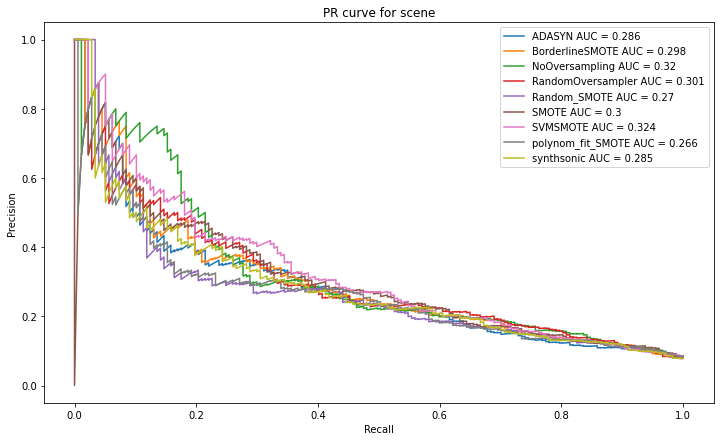

In [17]:
plot_pr(name, scene_prs, scene_recs, scene_aucs, oversampler_names)

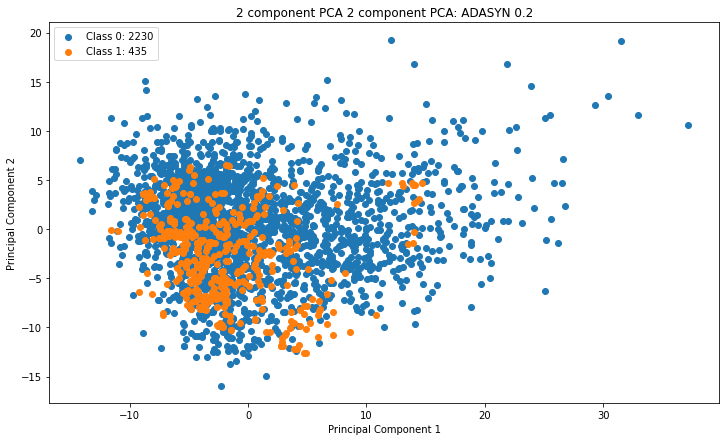

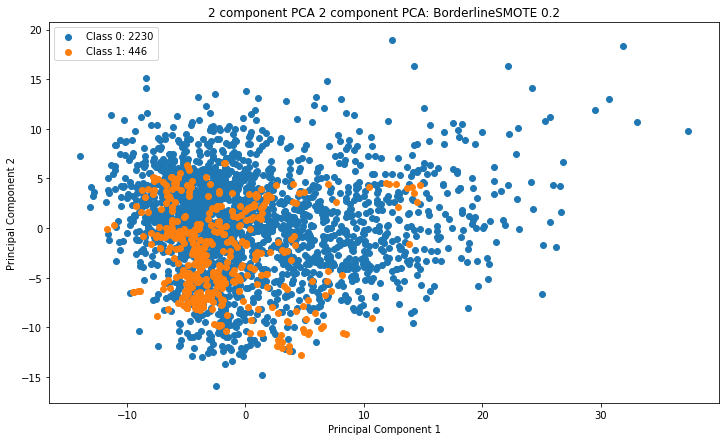

2021-08-30 11:40:10,379:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:40:10,379:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


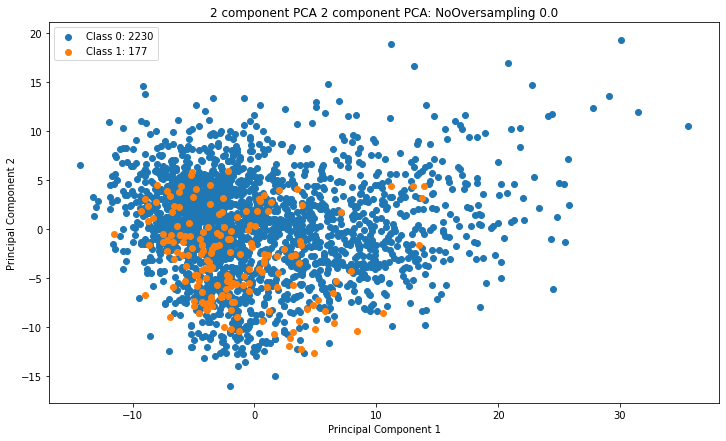

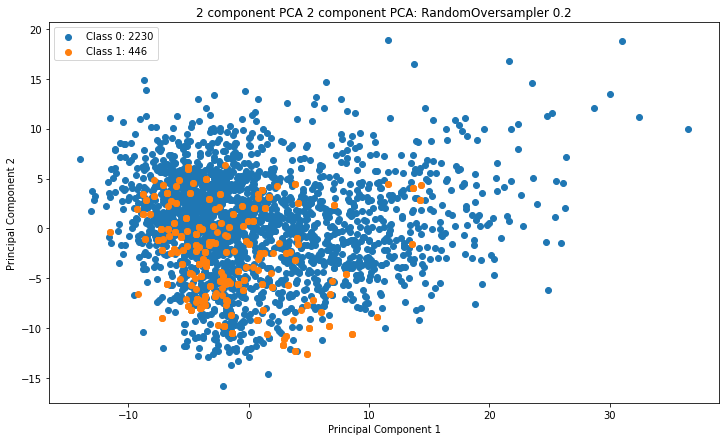

2021-08-30 11:40:10,858:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 11:40:10,858:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


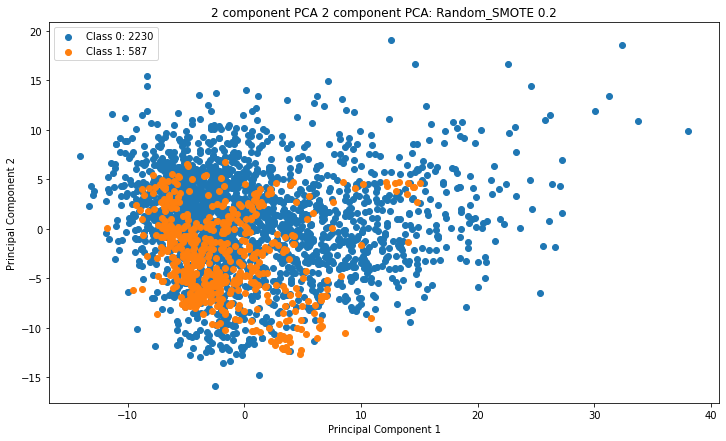

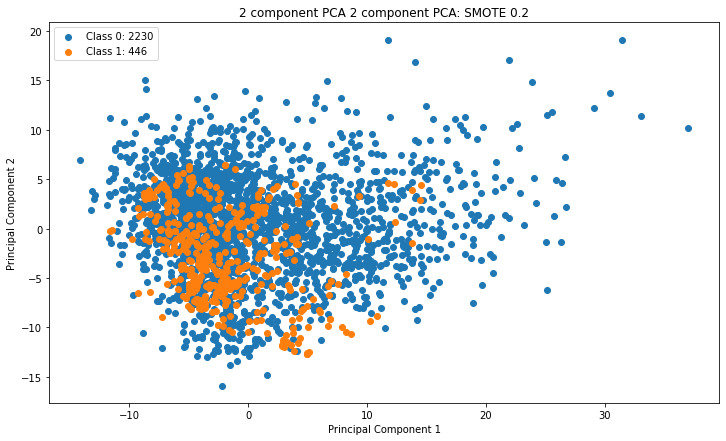

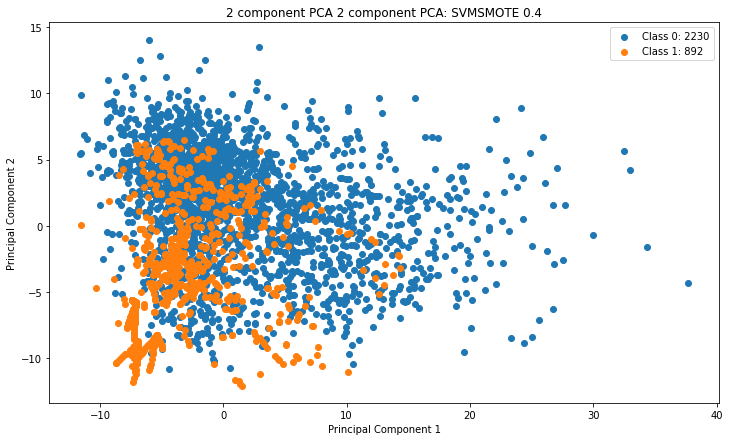

2021-08-30 11:40:12,697:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': 5}")
2021-08-30 11:40:12,697:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': 5}")


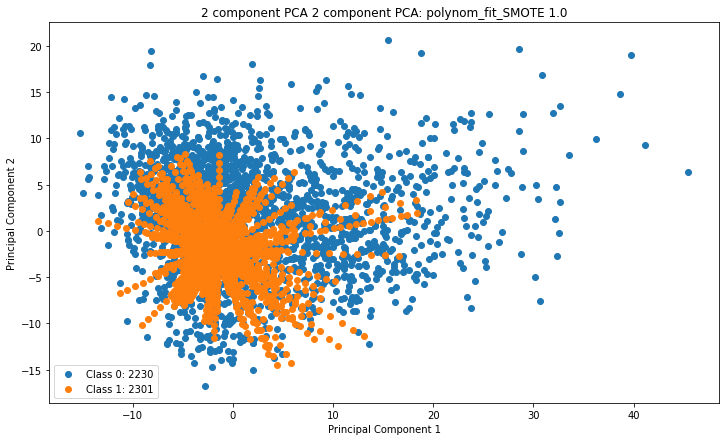

2021-08-30 11:40:13,084:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-30 11:40:13,084:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.4, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (177). n_quantiles is set to num samples.
Building tree: 100%|██████████| 42778/42778.0 [00:46<00:00, 923.56it/s] 
Generating for node: 7: 100%|██████████| 294/294 [00:20<00:00, 14.32it/s]  


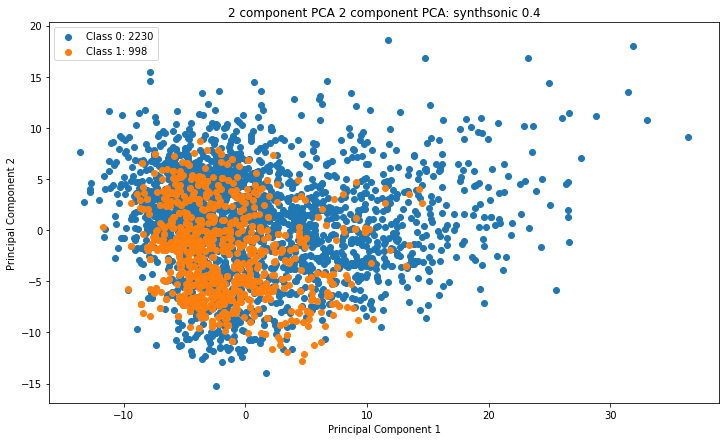

In [29]:
plot_pcas(X,y,oversamplers, oversampler_names,props)

# coil

In [25]:
X,y,name = HD.load_data('coil_2000')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [12]:
coil_prs, coil_recs, coil_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-27 14:15:50,884:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:15:50,884:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:15:51,427:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:15:51,427:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:15:51,971:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:15:51,971:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:15:52,521:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:15:52,521:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-27 14:15:55,971:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-27 14:15:55,971:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-27 14:15:57,745:INFO:Random_SMOTE: Running sampling via ('Random_SMO

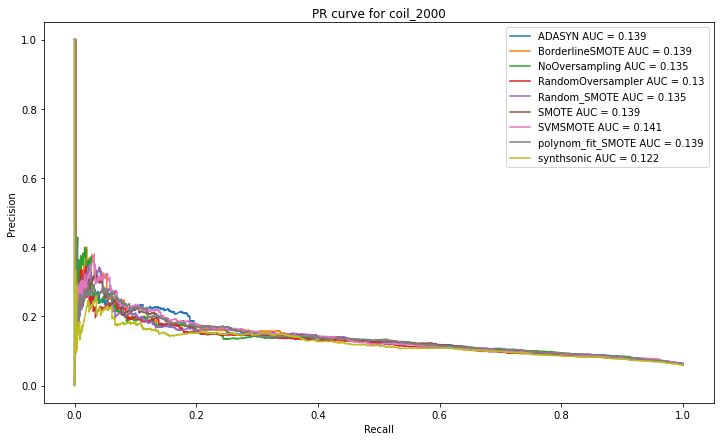

In [13]:
plot_pr(name, coil_prs, coil_recs, coil_aucs, oversampler_names)

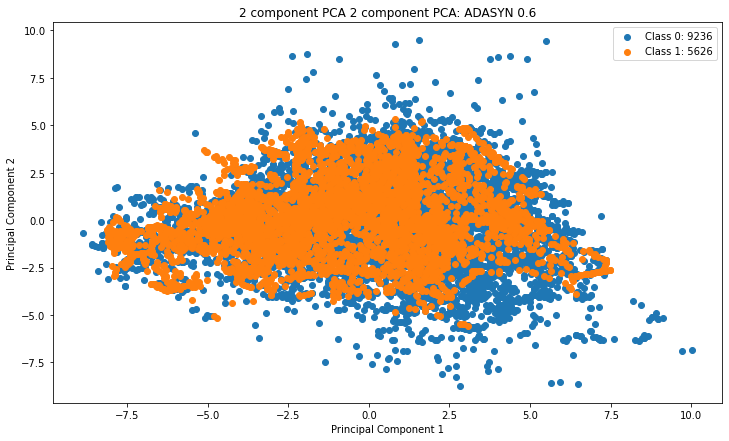

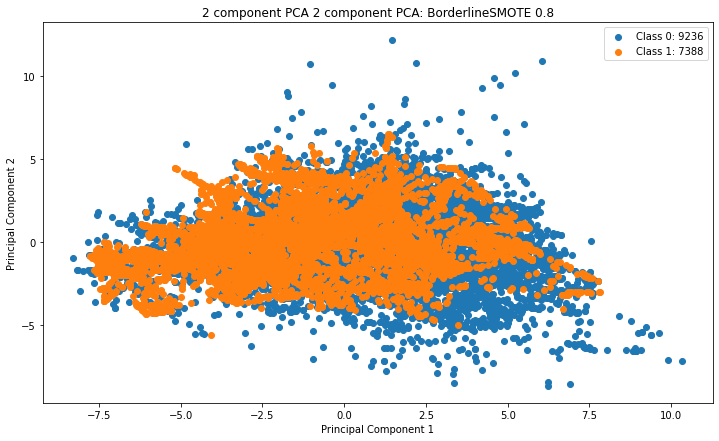

2021-08-30 11:36:30,832:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:36:30,832:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


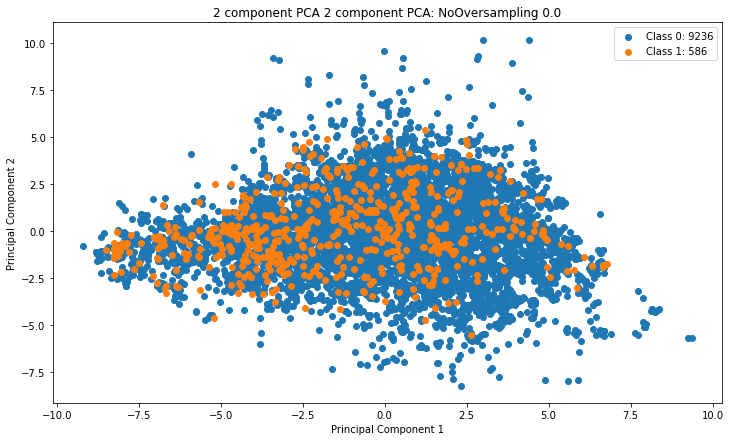

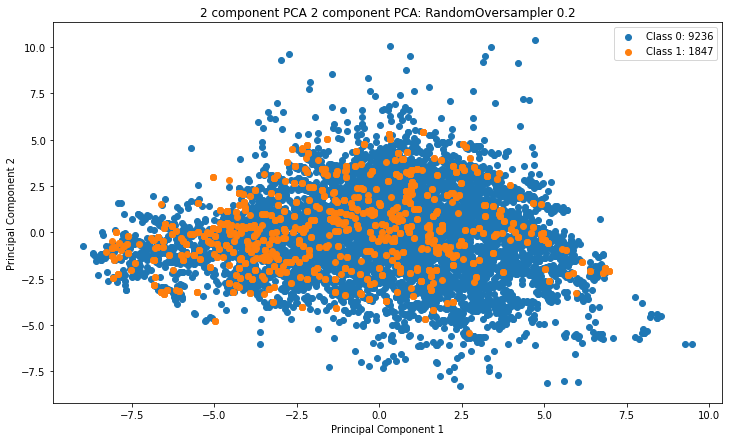

2021-08-30 11:36:31,453:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 11:36:31,453:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


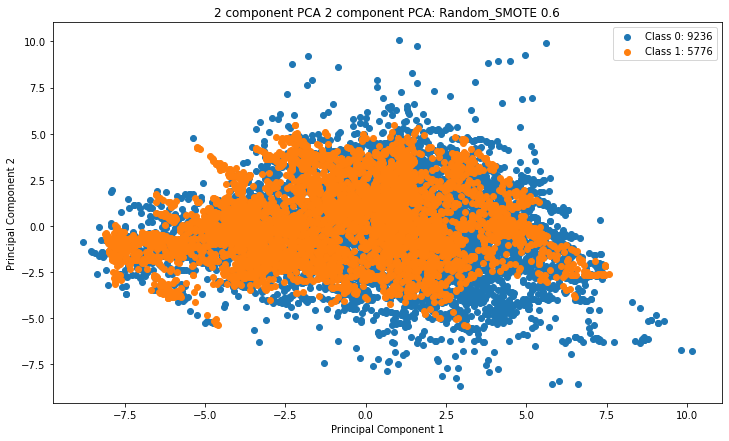

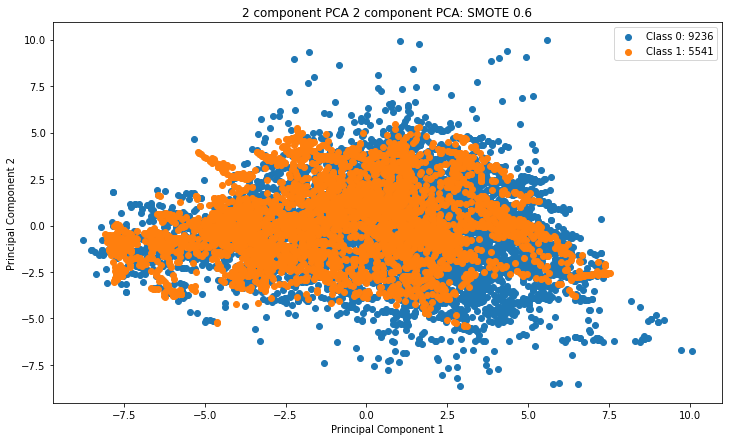

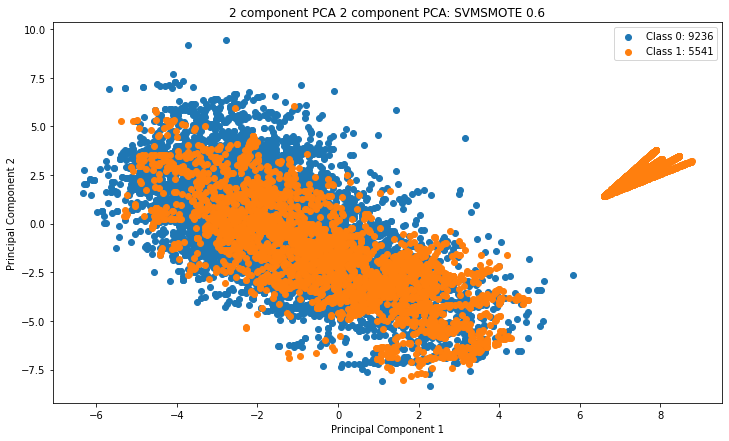

2021-08-30 11:36:36,603:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': 5}")
2021-08-30 11:36:36,603:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': 5}")


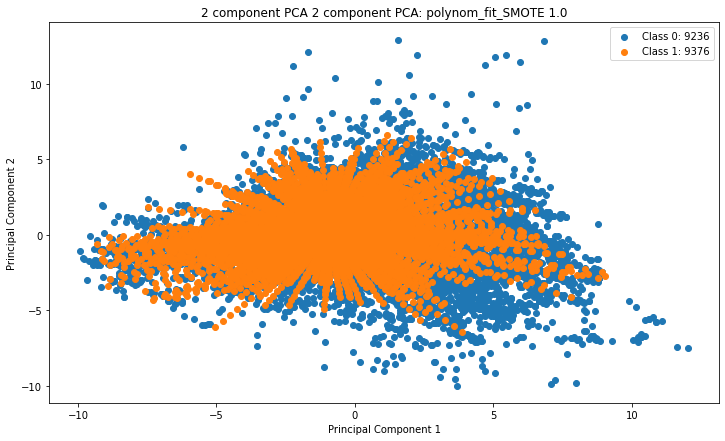

2021-08-30 11:36:37,034:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
2021-08-30 11:36:37,034:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.2, 'distinct_threshold': 20, 'do_PCA': True, 'ordering': 'pca'}")
Building tree: 100%|██████████| 3486/3486.0 [00:04<00:00, 864.78it/s]
Generating for node: 0:   1%|          | 1/85 [00:01<02:11,  1.57s/it]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 4: 100%|██████████| 85/85 [00:00<00:00, 102.15it/s] 


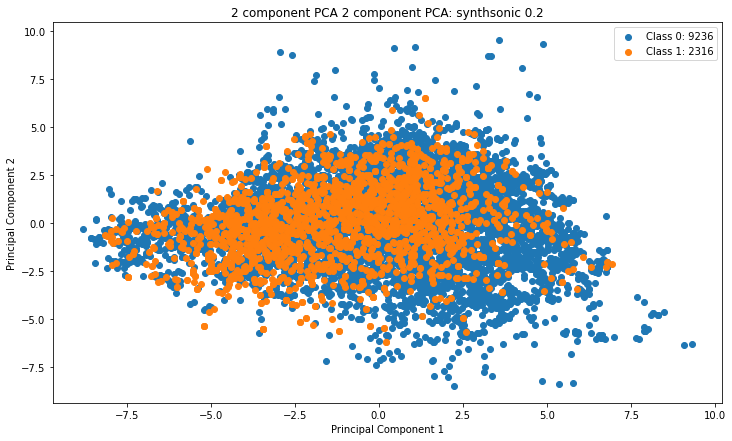

In [26]:
plot_pcas(X,y,oversamplers, oversampler_names,props)

# ozone

In [34]:
X,y,name = HD.load_data('ozone_level')
props = get_props(df, name)
df_info = HD.analyse_dataset(X,y,name, props)

In [15]:
ozone_prs, ozone_recs, ozone_aucs = calc_pr_auc(X,y,oversamplers, props)

2021-08-30 11:14:57,497:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:14:57,497:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:14:57,642:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:14:57,642:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:14:57,777:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:14:57,777:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:14:57,908:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:14:57,908:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 11:14:58,730:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 11:14:58,730:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 11:14:59,024:INFO:Random_SMOTE: Running sampling via ('Random_SMO

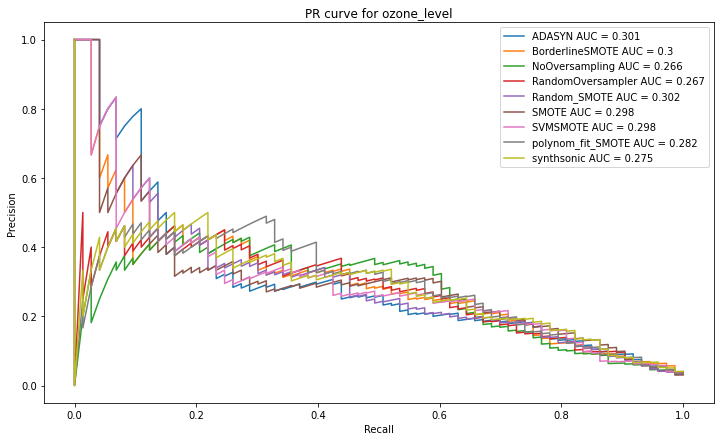

In [16]:
plot_pr(name, ozone_prs, ozone_recs, ozone_aucs, oversampler_names)

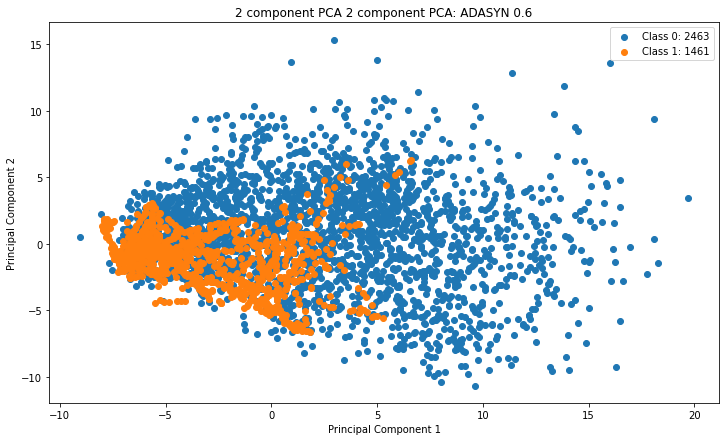

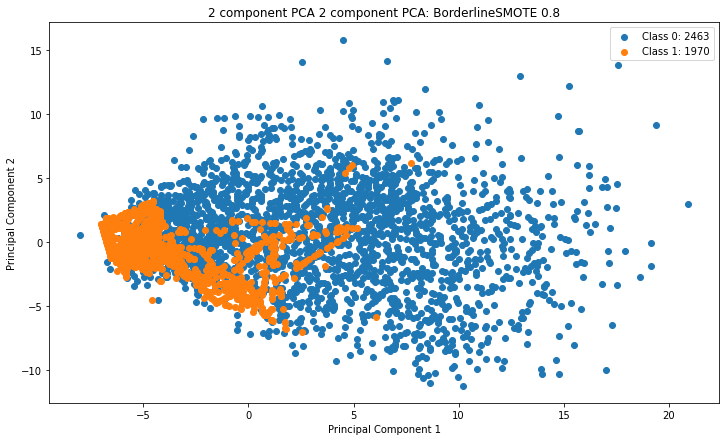

2021-08-30 12:04:01,341:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-08-30 12:04:01,341:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


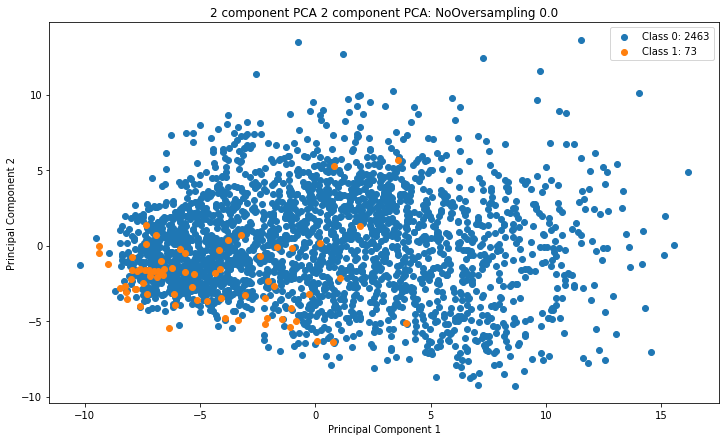

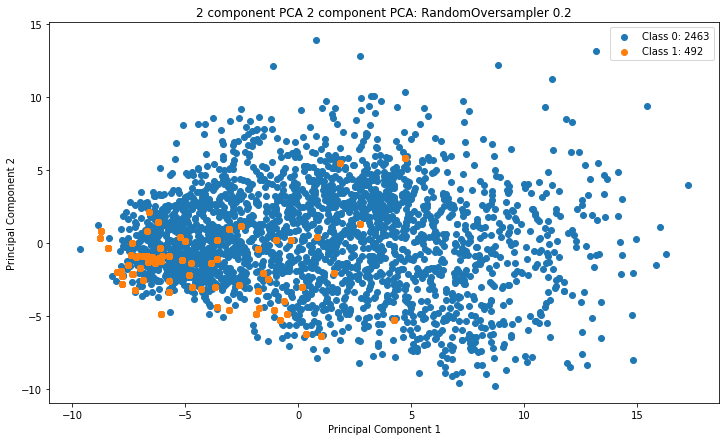

2021-08-30 12:04:01,703:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-08-30 12:04:01,703:INFO:Random_SMOTE: Running sampling via ('Random_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")


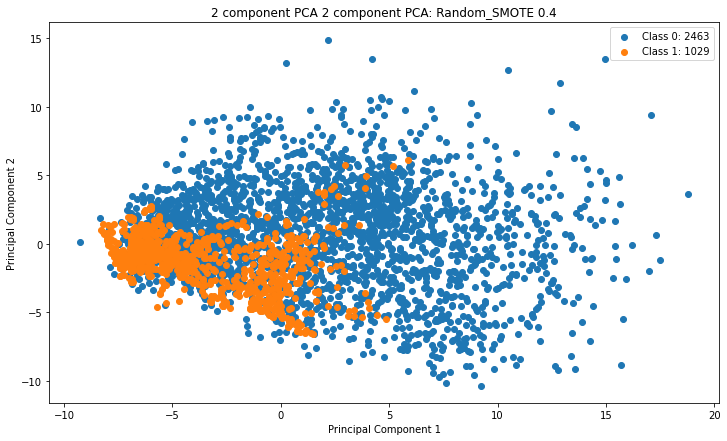

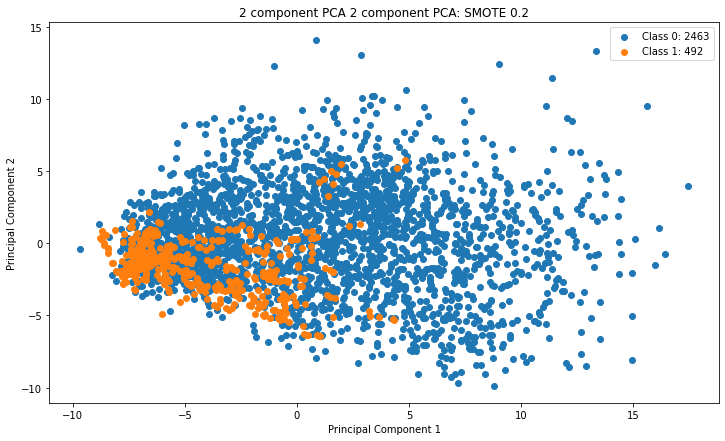

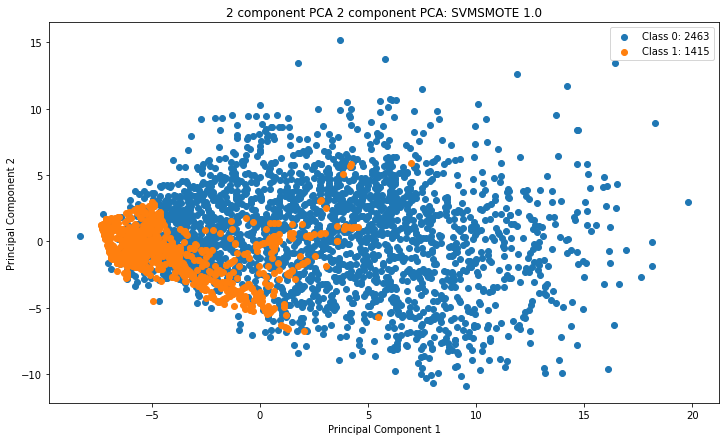

2021-08-30 12:04:02,654:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.2, 'topology': 'star', 'random_state': 5}")
2021-08-30 12:04:02,654:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.2, 'topology': 'star', 'random_state': 5}")


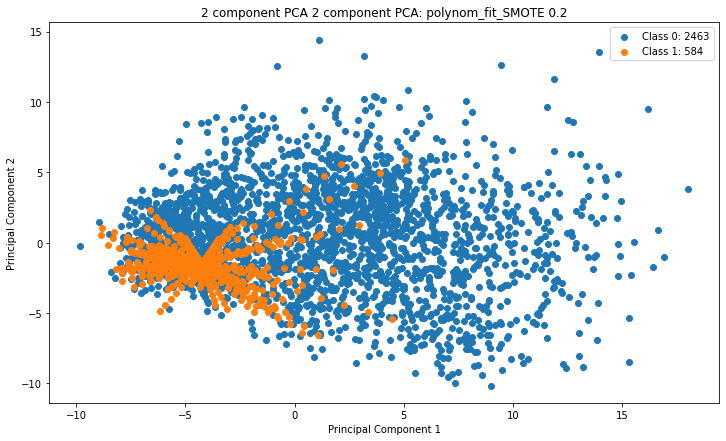

2021-08-30 12:04:03,022:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
2021-08-30 12:04:03,022:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.6, 'distinct_threshold': 20, 'do_PCA': False, 'ordering': ''}")
n_quantiles (500) is greater than the total number of samples (73). n_quantiles is set to num samples.
Building tree: 100%|██████████| 2485/2485.0 [00:02<00:00, 898.41it/s] 
Generating for node: 60: 100%|██████████| 72/72 [00:05<00:00, 14.17it/s]


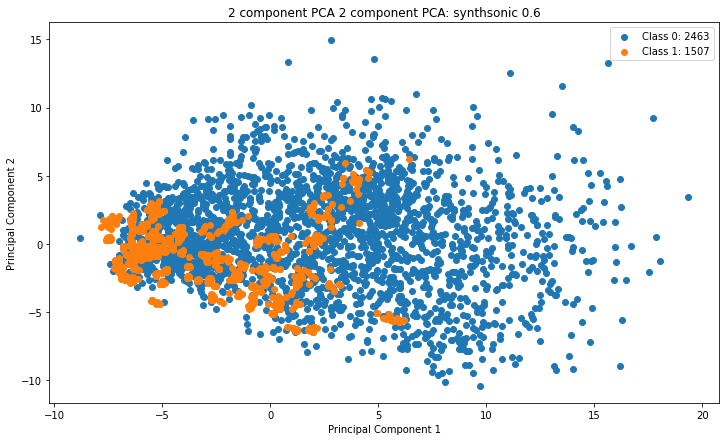

In [35]:
plot_pcas(X,y,oversamplers, oversampler_names,props)